In [1]:
from collections import defaultdict
import json
import glob, os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

INSTRUMENT_PREFIXES = {"chestnut", "confine", "sysfilter_extract", "syspart", "syspart_new", "go2seccomp"}

SYSCALL_MAP = {
    0: "read",
    1: "write",
    2: "open",
    3: "close",
    4: "stat",
    5: "fstat",
    6: "lstat",
    7: "poll",
    8: "lseek",
    9: "mmap",
    10: "mprotect",
    11: "munmap",
    12: "brk",
    13: "rt_sigaction",
    14: "rt_sigprocmask",
    15: "rt_sigreturn",
    16: "ioctl",
    17: "pread",
    18: "pwrite",
    19: "readv",
    20: "writev",
    21: "access",
    22: "pipe",
    23: "select",
    24: "sched_yield",
    25: "mremap",
    26: "msync",
    27: "mincore",
    28: "madvise",
    29: "shmget",
    30: "shmat",
    31: "shmctl",
    32: "dup",
    33: "dup2",
    34: "pause",
    35: "nanosleep",
    36: "getitimer",
    37: "alarm",
    38: "setitimer",
    39: "getpid",
    40: "sendfile",
    41: "socket",
    42: "connect",
    43: "accept",
    44: "sendto",
    45: "recvfrom",
    46: "sendmsg",
    47: "recvmsg",
    48: "shutdown",
    49: "bind",
    50: "listen",
    51: "getsockname",
    52: "getpeername",
    53: "socketpair",
    54: "setsockopt",
    55: "getsockopt",
    56: "clone",
    57: "fork",
    58: "vfork",
    59: "execve",
    60: "exit",
    61: "wait4",
    62: "kill",
    63: "uname",
    64: "semget",
    65: "semop",
    66: "semctl",
    67: "shmdt",
    68: "msgget",
    69: "msgsnd",
    70: "msgrcv",
    71: "msgctl",
    72: "fcntl",
    73: "flock",
    74: "fsync",
    75: "fdatasync",
    76: "truncate",
    77: "ftruncate",
    78: "getdents",
    79: "getcwd",
    80: "chdir",
    81: "fchdir",
    82: "rename",
    83: "mkdir",
    84: "rmdir",
    85: "creat",
    86: "link",
    87: "unlink",
    88: "symlink",
    89: "readlink",
    90: "chmod",
    91: "fchmod",
    92: "chown",
    93: "fchown",
    94: "lchown",
    95: "umask",
    96: "gettimeofday",
    97: "getrlimit",
    98: "getrusage",
    99: "sysinfo",
    100: "times",
    101: "ptrace",
    102: "getuid",
    103: "syslog",
    104: "getgid",
    105: "setuid",
    106: "setgid",
    107: "geteuid",
    108: "getegid",
    109: "setpgid",
    110: "getppid",
    111: "getpgrp",
    112: "setsid",
    113: "setreuid",
    114: "setregid",
    115: "getgroups",
    116: "setgroups",
    117: "setresuid",
    118: "getresuid",
    119: "setresgid",
    120: "getresgid",
    121: "getpgid",
    122: "setfsuid",
    123: "setfsgid",
    124: "getsid",
    125: "capget",
    126: "capset",
    127: "rt_sigpending",
    128: "rt_sigtimedwait",
    129: "rt_sigqueueinfo",
    130: "rt_sigsuspend",
    131: "sigaltstack",
    132: "utime",
    133: "mknod",
    134: "uselib",
    135: "personality",
    136: "ustat",
    137: "statfs",
    138: "fstatfs",
    139: "sysfs",
    140: "getpriority",
    141: "setpriority",
    142: "sched_setparam",
    143: "sched_getparam",
    144: "sched_setscheduler",
    145: "sched_getscheduler",
    146: "sched_get_priority_max",
    147: "sched_get_priority_min",
    148: "sched_rr_get_interval",
    149: "mlock",
    150: "munlock",
    151: "mlockall",
    152: "munlockall",
    153: "vhangup",
    154: "modify_ldt",
    155: "pivot_root",
    156: "_sysctl",
    157: "prctl",
    158: "arch_prctl",
    159: "adjtimex",
    160: "setrlimit",
    161: "chroot",
    162: "sync",
    163: "acct",
    164: "settimeofday",
    165: "mount",
    166: "umount2",
    167: "swapon",
    168: "swapoff",
    169: "reboot",
    170: "sethostname",
    171: "setdomainname",
    172: "iopl",
    173: "ioperm",
    174: "create_module",
    175: "init_module",
    176: "delete_module",
    177: "get_kernel_syms",
    178: "query_module",
    179: "quotactl",
    180: "nfsservctl",
    181: "getpmsg",
    182: "putpmsg",
    183: "afs_syscall",
    184: "tuxcall",
    185: "security",
    186: "gettid",
    187: "readahead",
    188: "setxattr",
    189: "lsetxattr",
    190: "fsetxattr",
    191: "getxattr",
    192: "lgetxattr",
    193: "fgetxattr",
    194: "listxattr",
    195: "llistxattr",
    196: "flistxattr",
    197: "removexattr",
    198: "lremovexattr",
    199: "fremovexattr",
    200: "tkill",
    201: "time",
    202: "futex",
    203: "sched_setaffinity",
    204: "sched_getaffinity",
    205: "set_thread_area",
    206: "io_setup",
    207: "io_destroy",
    208: "io_getevents",
    209: "io_submit",
    210: "io_cancel",
    211: "get_thread_area",
    212: "lookup_dcookie",
    213: "epoll_create",
    214: "epoll_ctl_old",
    215: "epoll_wait_old",
    216: "remap_file_pages",
    217: "getdents64",
    218: "set_tid_address",
    219: "restart_syscall",
    220: "semtimedop",
    221: "fadvise64",
    222: "timer_create",
    223: "timer_settime",
    224: "timer_gettime",
    225: "timer_getoverrun",
    226: "timer_delete",
    227: "clock_settime",
    228: "clock_gettime",
    229: "clock_getres",
    230: "clock_nanosleep",
    231: "exit_group",
    232: "epoll_wait",
    233: "epoll_ctl",
    234: "tgkill",
    235: "utimes",
    236: "vserver",
    237: "mbind",
    238: "set_mempolicy",
    239: "get_mempolicy",
    240: "mq_open",
    241: "mq_unlink",
    242: "mq_timedsend",
    243: "mq_timedreceive",
    244: "mq_notify",
    245: "mq_getsetattr",
    246: "kexec_load",
    247: "waitid",
    248: "add_key",
    249: "request_key",
    250: "keyctl",
    251: "ioprio_set",
    252: "ioprio_get",
    253: "inotify_init",
    254: "inotify_add_watch",
    255: "inotify_rm_watch",
    256: "migrate_pages",
    257: "openat",
    258: "mkdirat",
    259: "mknodat",
    260: "fchownat",
    261: "futimesat",
    262: "newfstatat",
    263: "unlinkat",
    264: "renameat",
    265: "linkat",
    266: "symlinkat",
    267: "readlinkat",
    268: "fchmodat",
    269: "faccessat",
    270: "pselect6",
    271: "ppoll",
    272: "unshare",
    273: "set_robust_list",
    274: "get_robust_list",
    275: "splice",
    276: "tee",
    277: "sync_file_range",
    278: "vmsplice",
    279: "move_pages",
    280: "utimensat",
    281: "epoll_pwait",
    282: "signalfd",
    283: "timerfd",
    284: "eventfd",
    285: "fallocate",
    286: "timerfd_settime",
    287: "timerfd_gettime",
    288: "accept4",
    289: "signalfd4",
    290: "eventfd2",
    291: "epoll_create1",
    292: "dup3",
    293: "pipe2",
    294: "inotify_init1",
    295: "preadv",
    296: "pwritev",
    297: "rt_tgsigqueueinfo",
    298: "perf_event_open",
    299: "recvmmsg",
    300: "fanotify_init",
    301: "fanotify_mark",
    302: "prlimit64",
    303: "name_to_handle_at",
    304: "open_by_handle_at",
    305: "clock_adjtime",
    306: "syncfs",
    307: "sendmmsg",
    308: "setns",
    309: "getcpu",
    310: "process_vm_readv",
    311: "process_vm_writev",
    312: "kcmp",
    313: "finit_module",
    314: "sched_setattr",
    315: "sched_getattr",
    316: "renameat2",
    317: "seccomp",
    318: "getrandom",
    319: "memfd_create",
    320: "kexec_file_load",
    321: "bpf",
    322: "execveat",
    323: "userfaultfd",
    324: "membarrier",
    325: "mlock2",
    326: "copy_file_range",
    327: "preadv2",
    328: "pwritev2",
    329: "pkey_mprotect",
    330: "pkey_alloc",
    331: "pkey_free",
    332: "statx",
}

In [2]:
def process_syscall_files(base_path):
    results = dict()
    strace_files = glob.glob(f'{base_path}/*/*/*.syscalls', recursive=True)
    
    print(f"Найдено {len(strace_files)} syscalls файлов")
    
    for strace_file in strace_files:
        base_name = os.path.basename(strace_file).split(".")[0]
        with open(strace_file, "r") as file:
            results[base_name] = set(filter(None, file.read().split("\n")))

    return results

build_syscalls = process_syscall_files('build/build')

Найдено 1190 syscalls файлов


In [3]:
def extract_syscalls_from_instruments(workspace_path):
    
    workspace_files = glob.glob(f'{workspace_path}/syscall_results/*/*', recursive=True)
    workspace_files = [
        _file_path 
        for _file_path in workspace_files
        if "opt__test__build__" in _file_path
    ]
    
    exit_codes = {
        (file_path.split("__")[-1].split("/")[0], file_path.split("__")[-1].split("/")[1].removesuffix(".exitcode")): int(list(filter(None, open(file_path).read().split('\n')))[0])
        for file_path in workspace_files
        if file_path.endswith(".exitcode")
    }

    result = {}

    for file_path in workspace_files:
        splitted_path = file_path.split("__")
        test_name, file_name = splitted_path[-1].split("/")
        instrument, extension = file_name.split(".", maxsplit=1)
        exit_code = exit_codes.get((test_name, instrument), None)
        if exit_code is None:
            continue
        if exit_code != 0:
            continue
        if extension == "syscalls.json" and instrument == "chestnut":
            with open(file_path, "r") as file:
                syscalls = list(map(lambda el: SYSCALL_MAP.get(el, "unknown"), json.load(file)))
                result[(test_name, instrument)] = set(syscalls)
        if extension == "syscalls.json" and instrument == "sysfilter_extract":
            with open(file_path, "r") as file:
                syscalls = list(map(lambda el: SYSCALL_MAP.get(el, "unknown"), json.load(file)))
                result[(test_name, instrument)] = set(syscalls)
        if extension == "syscalls.txt" and instrument == "syspart":
            with open(file_path, "r") as file:                
                result[(test_name, instrument)] = set(file.read().split("\n"))
        if extension == "syscalls.txt" and instrument == "confine":
            with open(file_path, "r") as file:                
                result[(test_name, instrument)] = set(file.read().split("\n"))
        if extension == "syscalls.txt" and instrument == "syspart_new":
            with open(file_path, "r") as file:                
                result[(test_name, instrument)] = set(file.read().split("\n"))
        if extension == "syscalls.txt" and instrument == "go2seccomp":
            with open(file_path, "r") as file:                
                result[(test_name, instrument)] = set(file.read().split("\n"))

    return result

workspace_results = extract_syscalls_from_instruments('build/workspace')

[scan] files scanned: 31846
[scan] pred_sets pairs: 5610 | exit_codes pairs: 7140
[df] rows: 7140 (tests=1190 × instruments=6)


,suite,test,instrument,exit_code,success,tp,fp,fn,tn,precision,...,f1,lang,strip,pie_mode,lto_mode,compiler,opt,lto,pie,link
0,t01,t01_api_c_clang_O0_lto_nopie_dyn,chestnut,0,True,17,254,0,62,0.062731,...,0.118056,c,nostrip,nopie,lto,clang,O0,lto,nopie,dyn
1,t01,t01_api_c_clang_O0_lto_nopie_dyn,sysfilter_extract,0,True,11,36,6,280,0.234043,...,0.343750,c,nostrip,nopie,lto,clang,O0,lto,nopie,dyn
2,t01,t01_api_c_clang_O0_lto_nopie_dyn,syspart_new,0,True,10,28,7,288,0.263158,...,0.363636,c,nostrip,nopie,lto,clang,O0,lto,nopie,dyn


[intersection] tests succeeded for ALL instruments: 28 / 1190


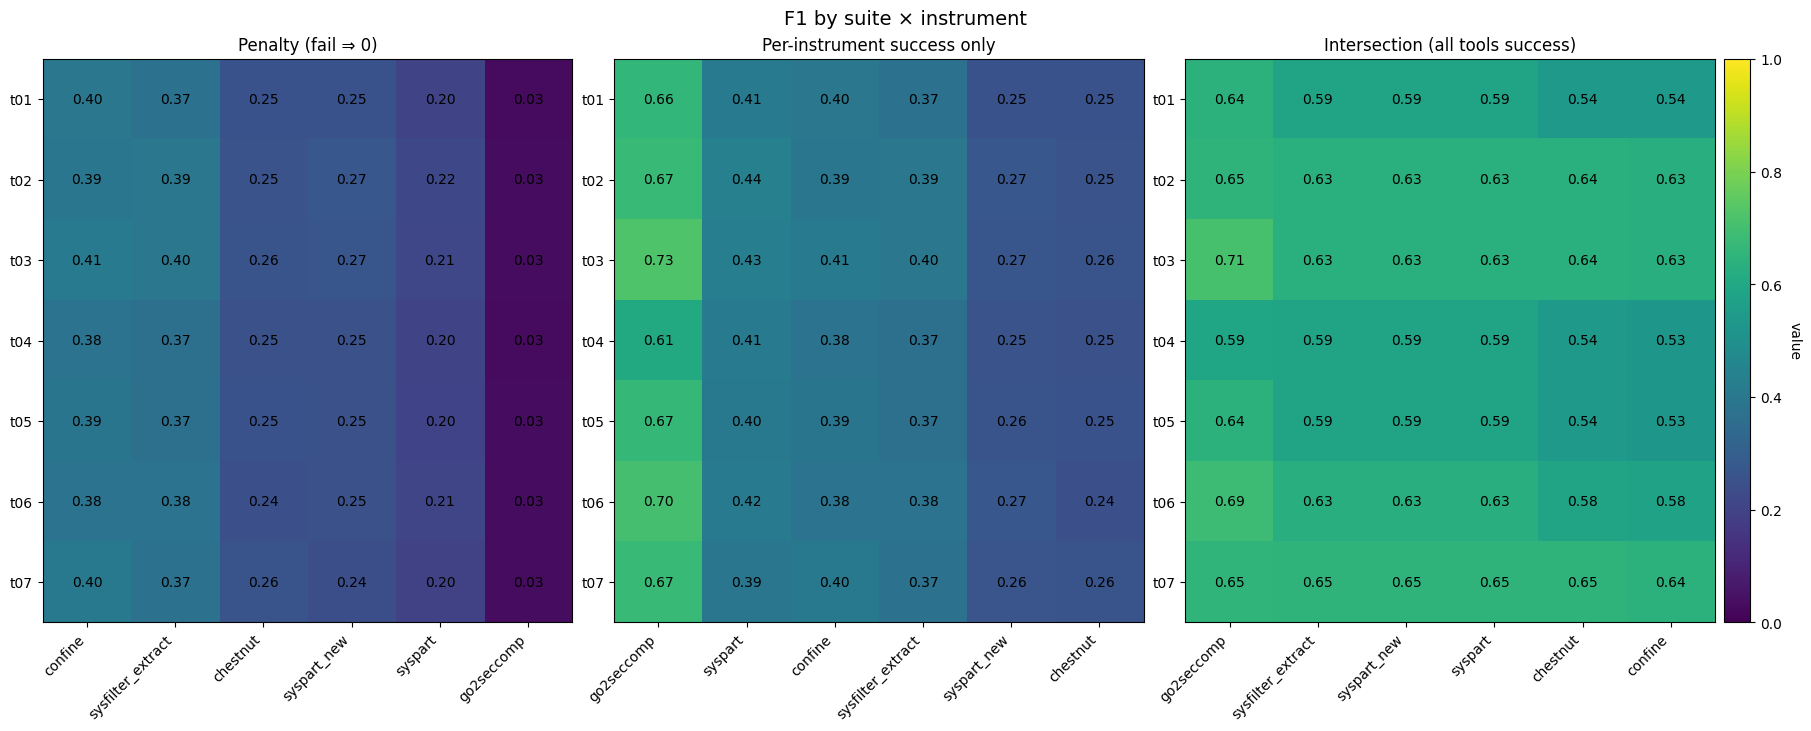

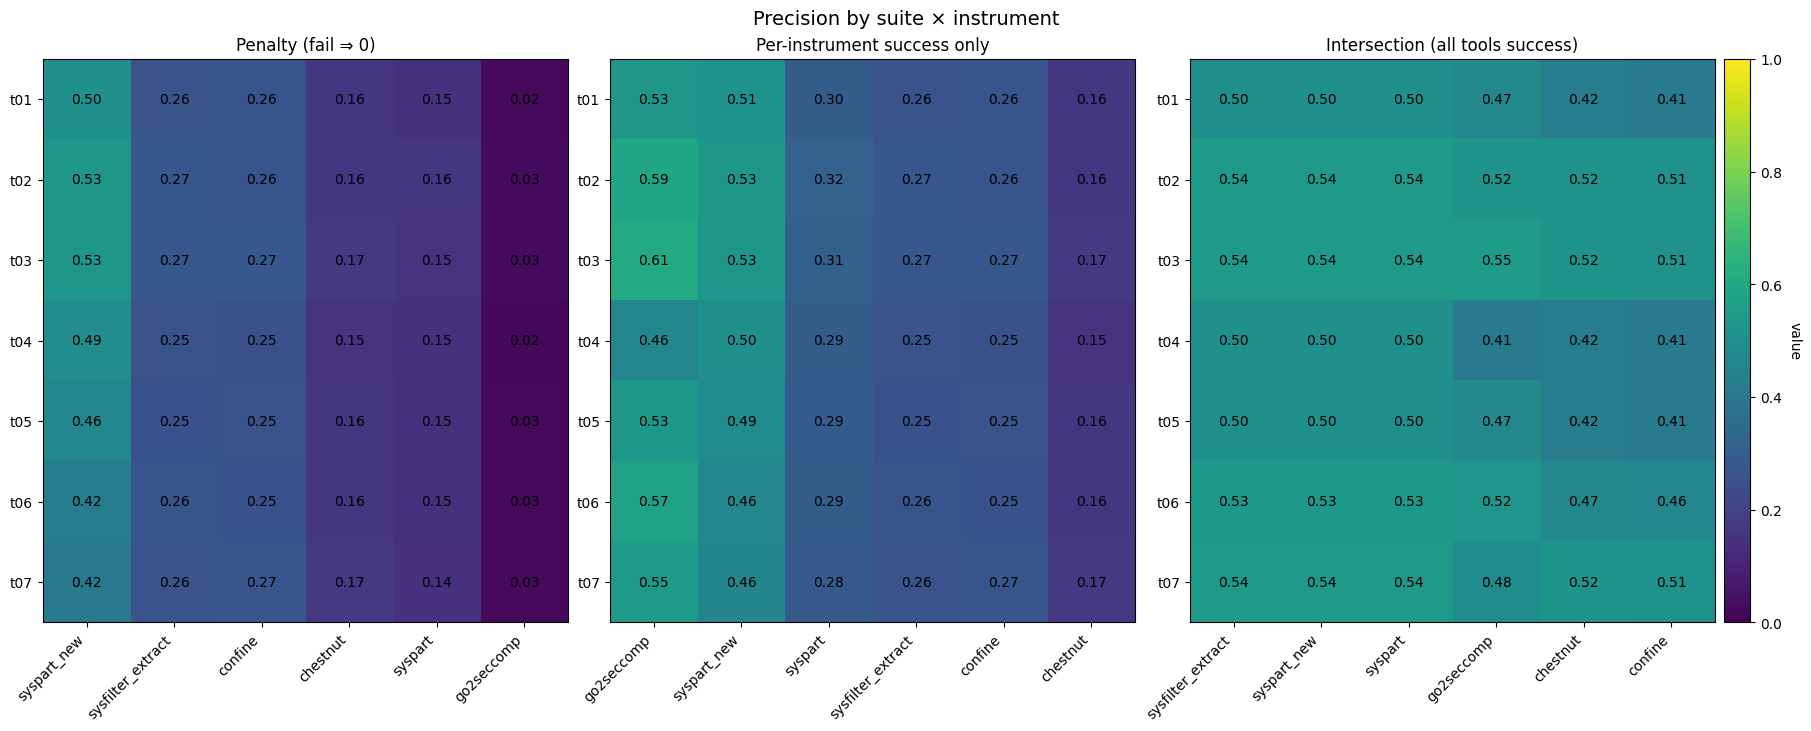

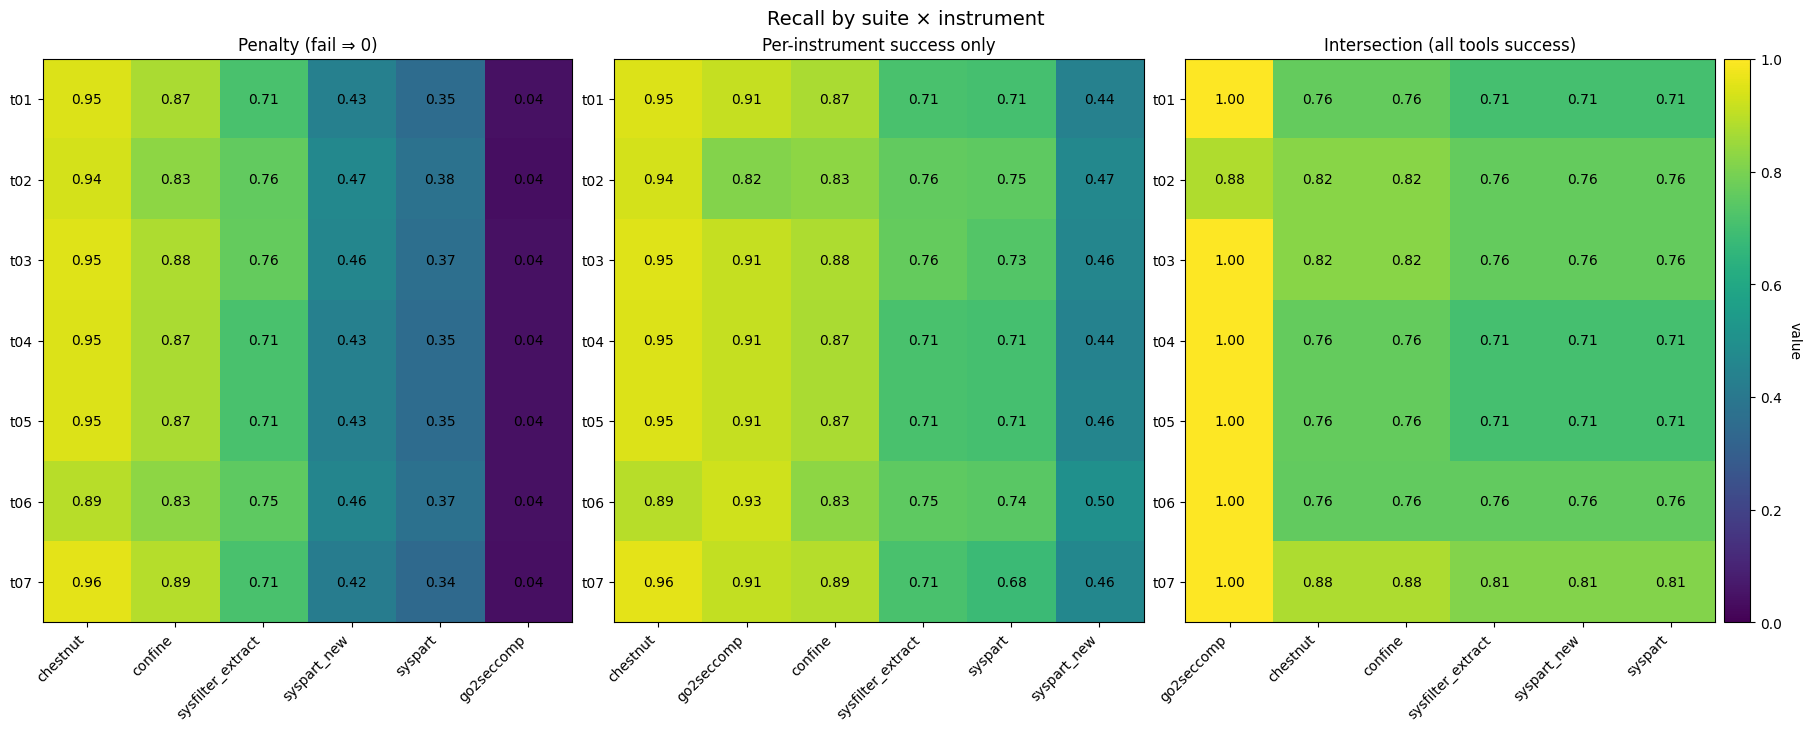

[lang] ['c', 'cpp', 'go', 'rust']


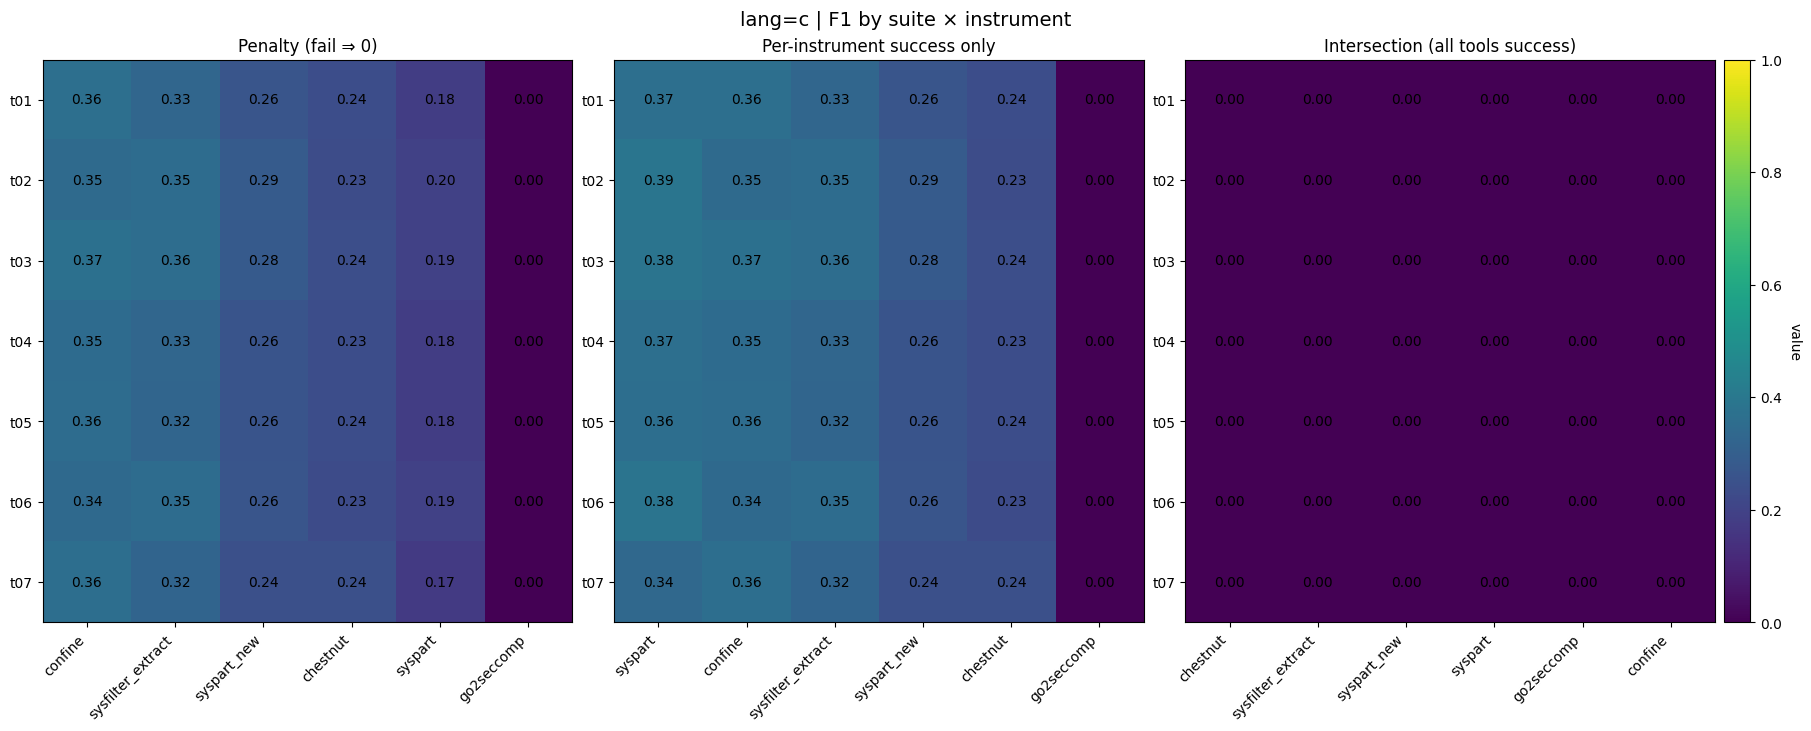

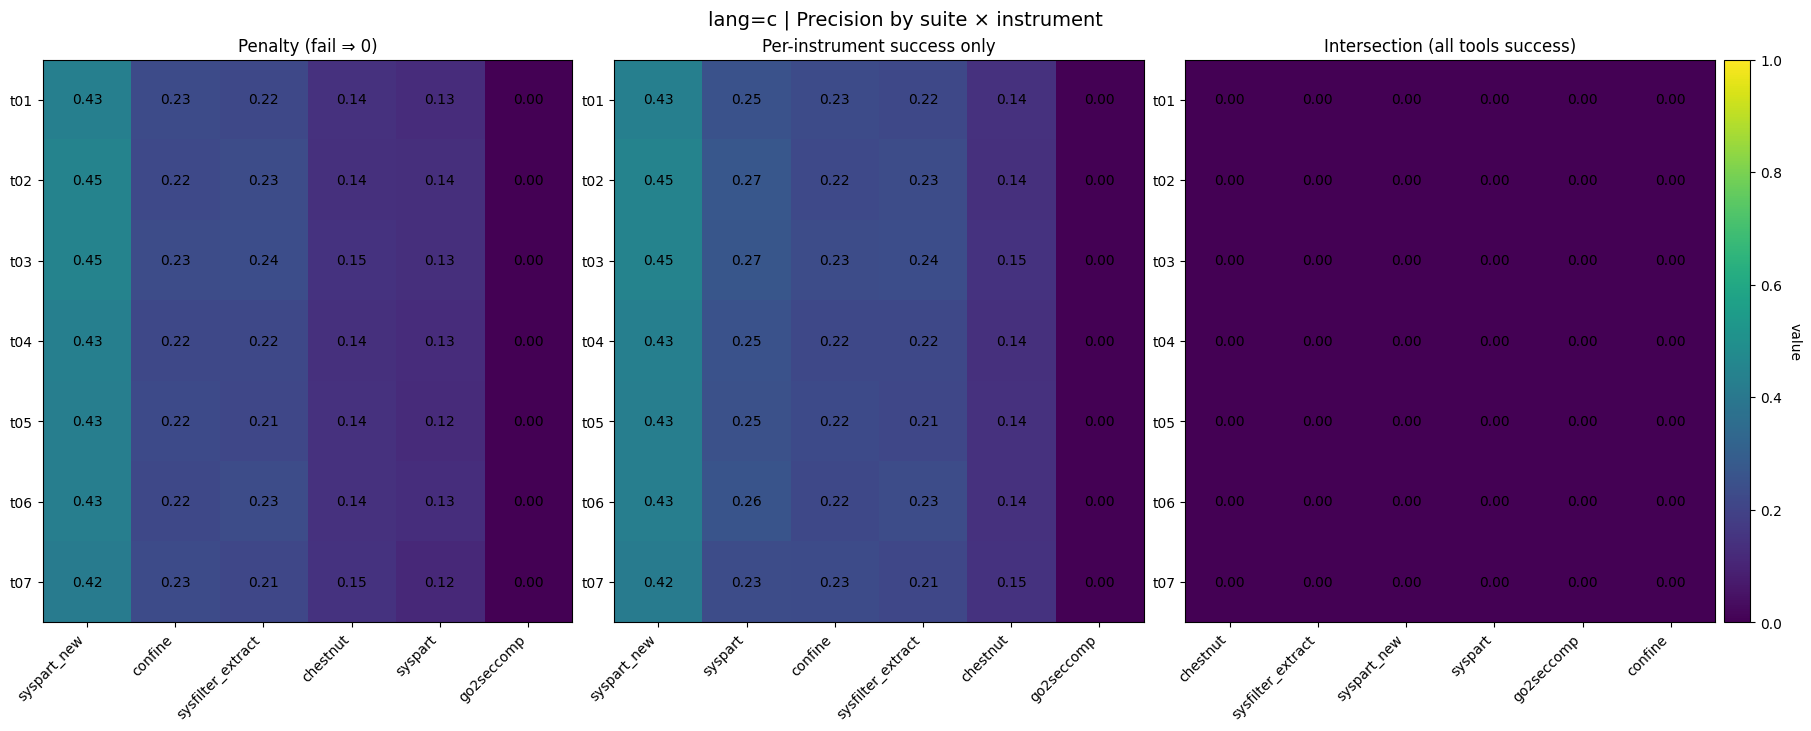

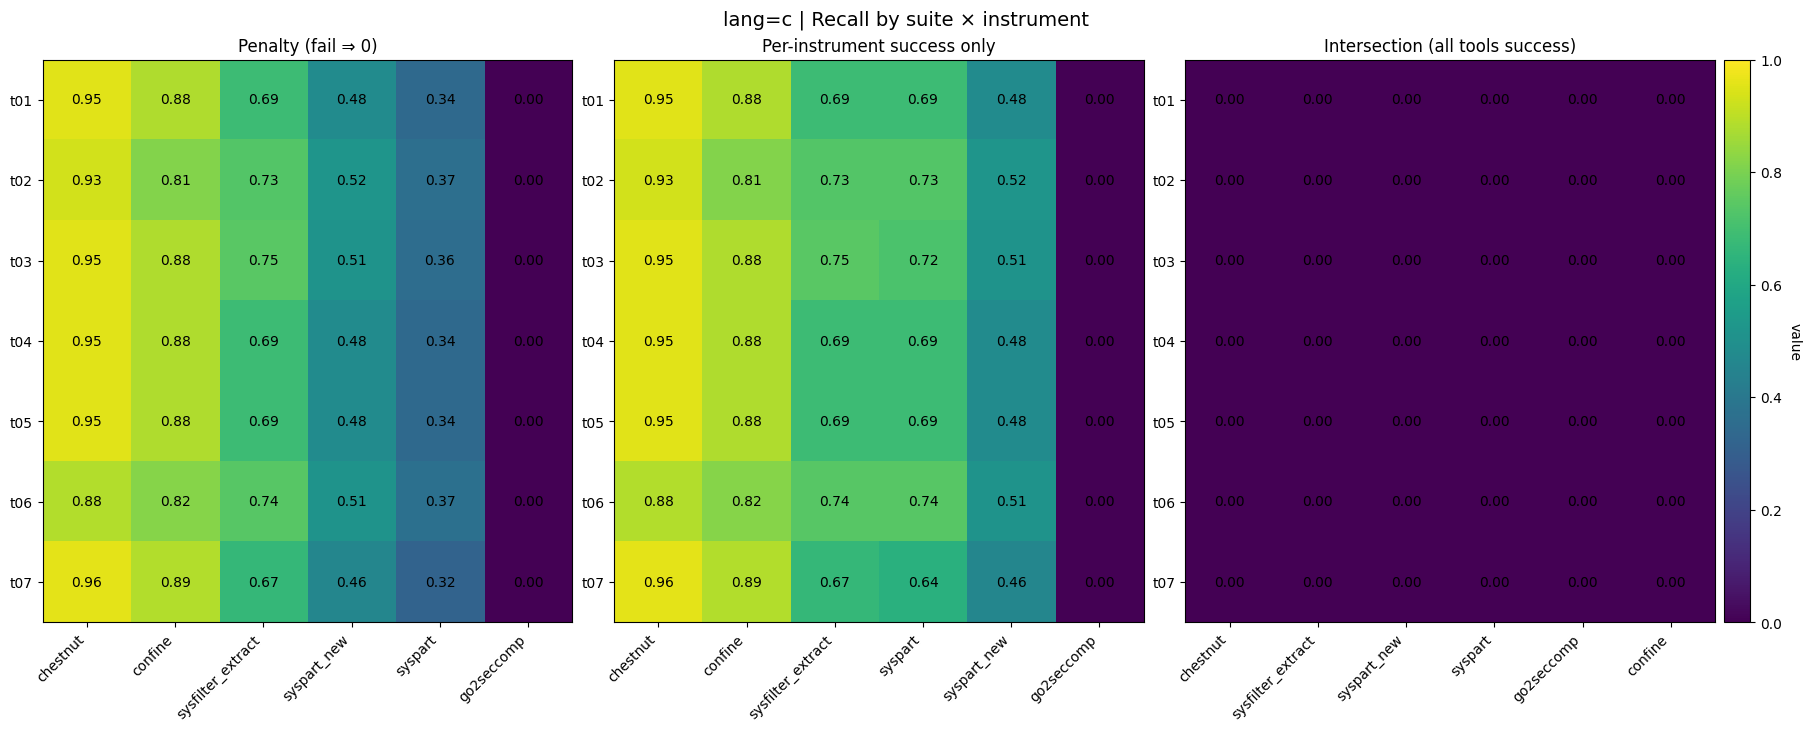

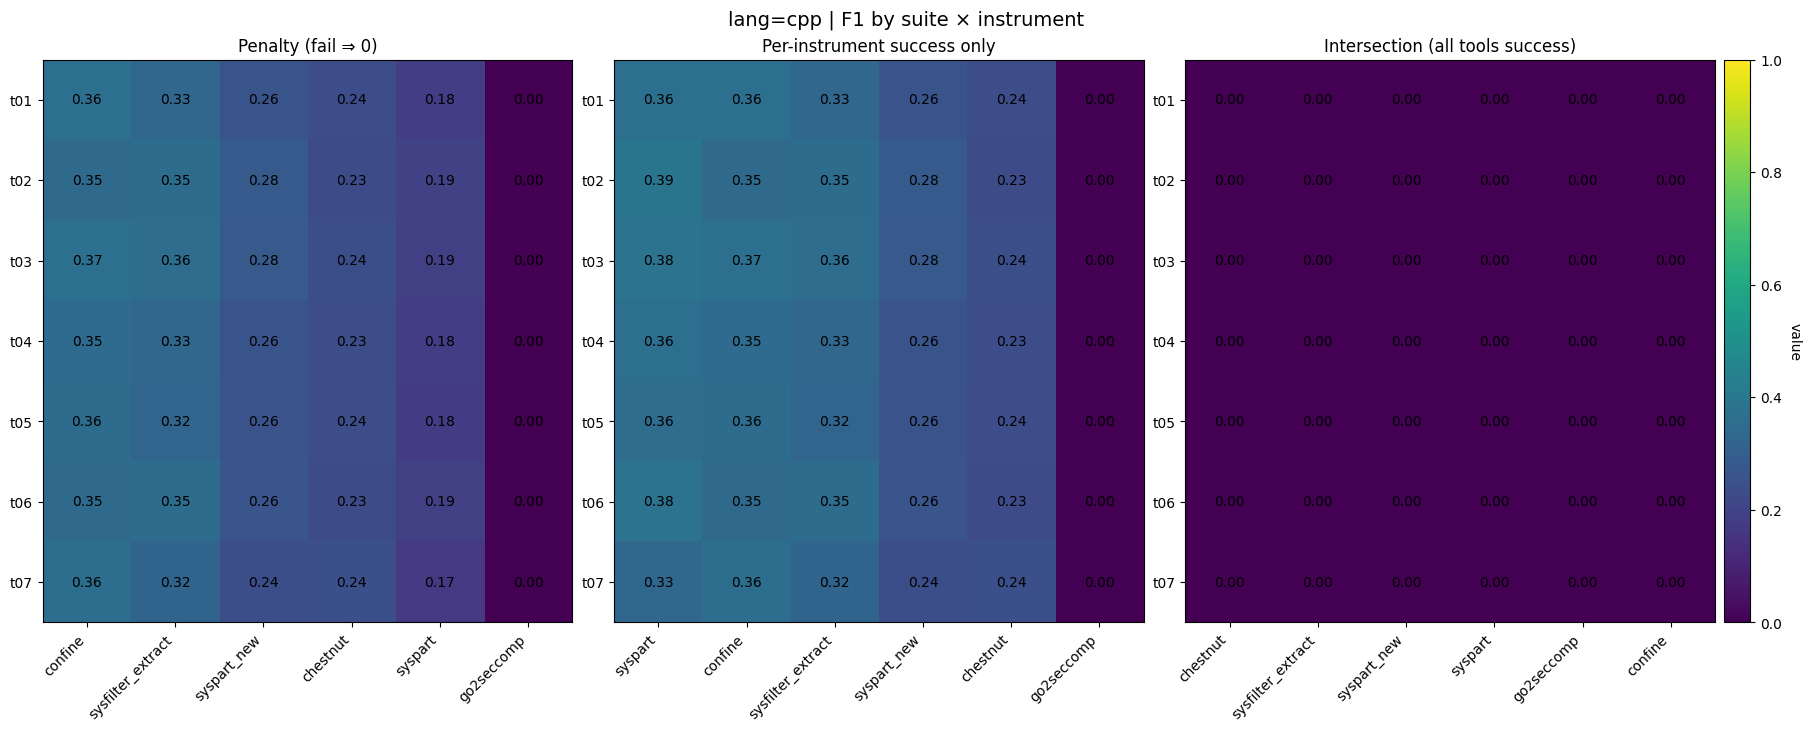

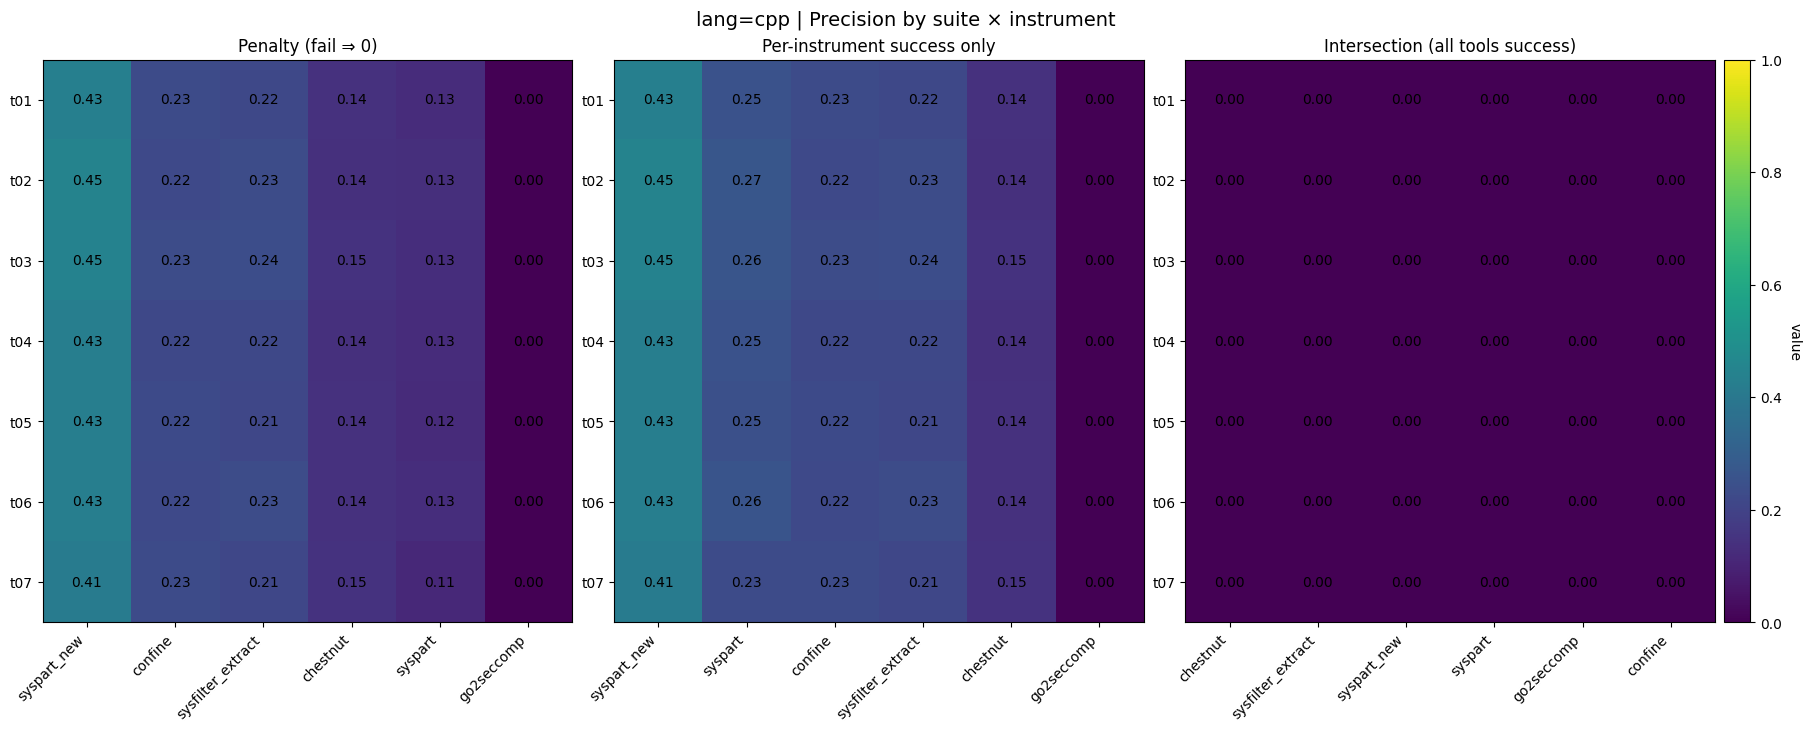

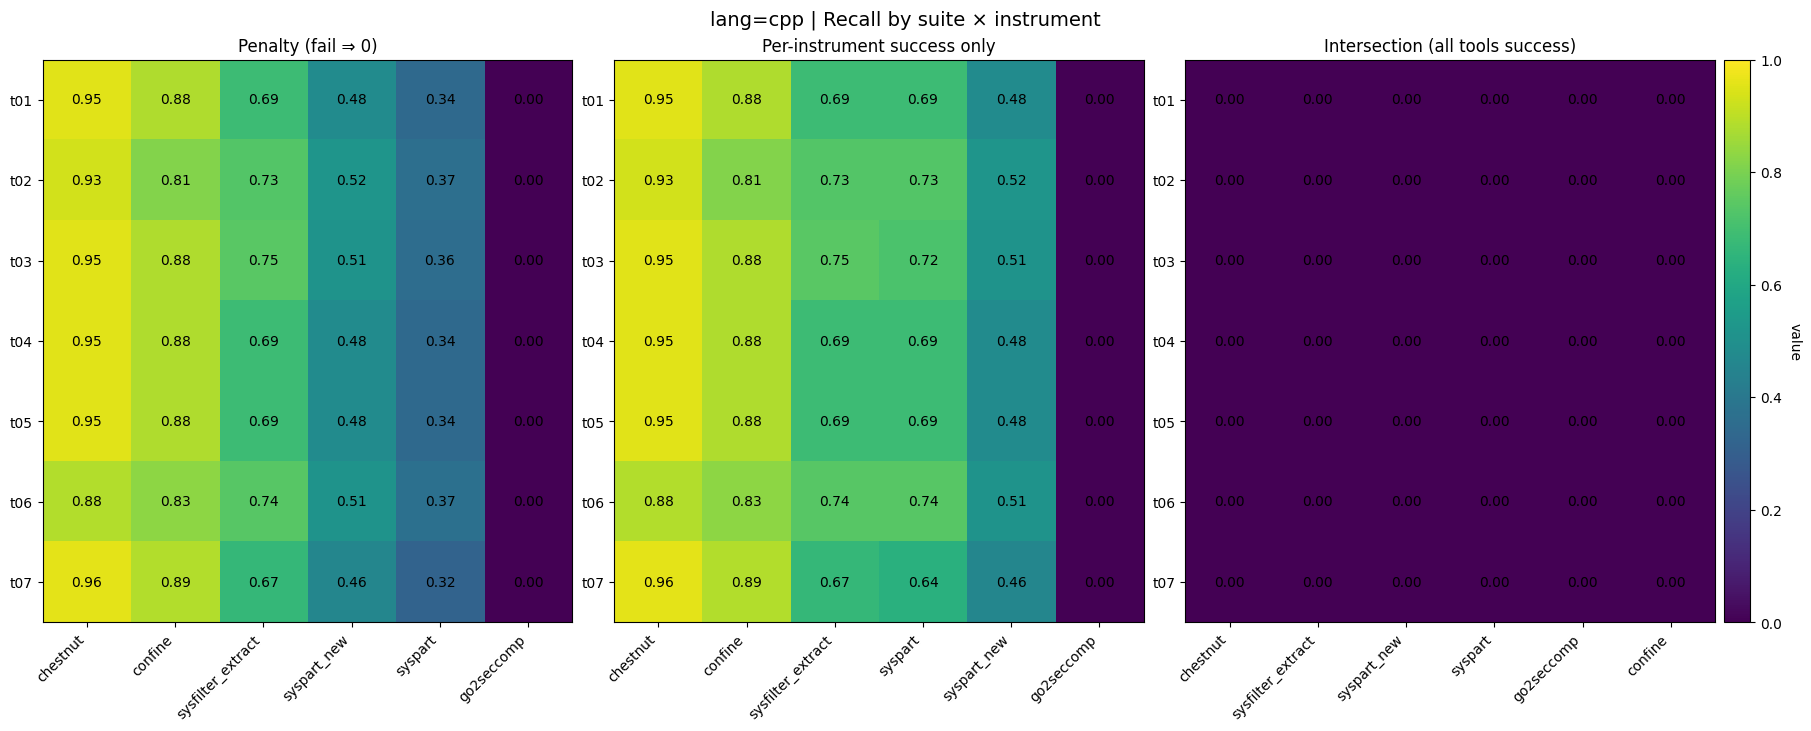

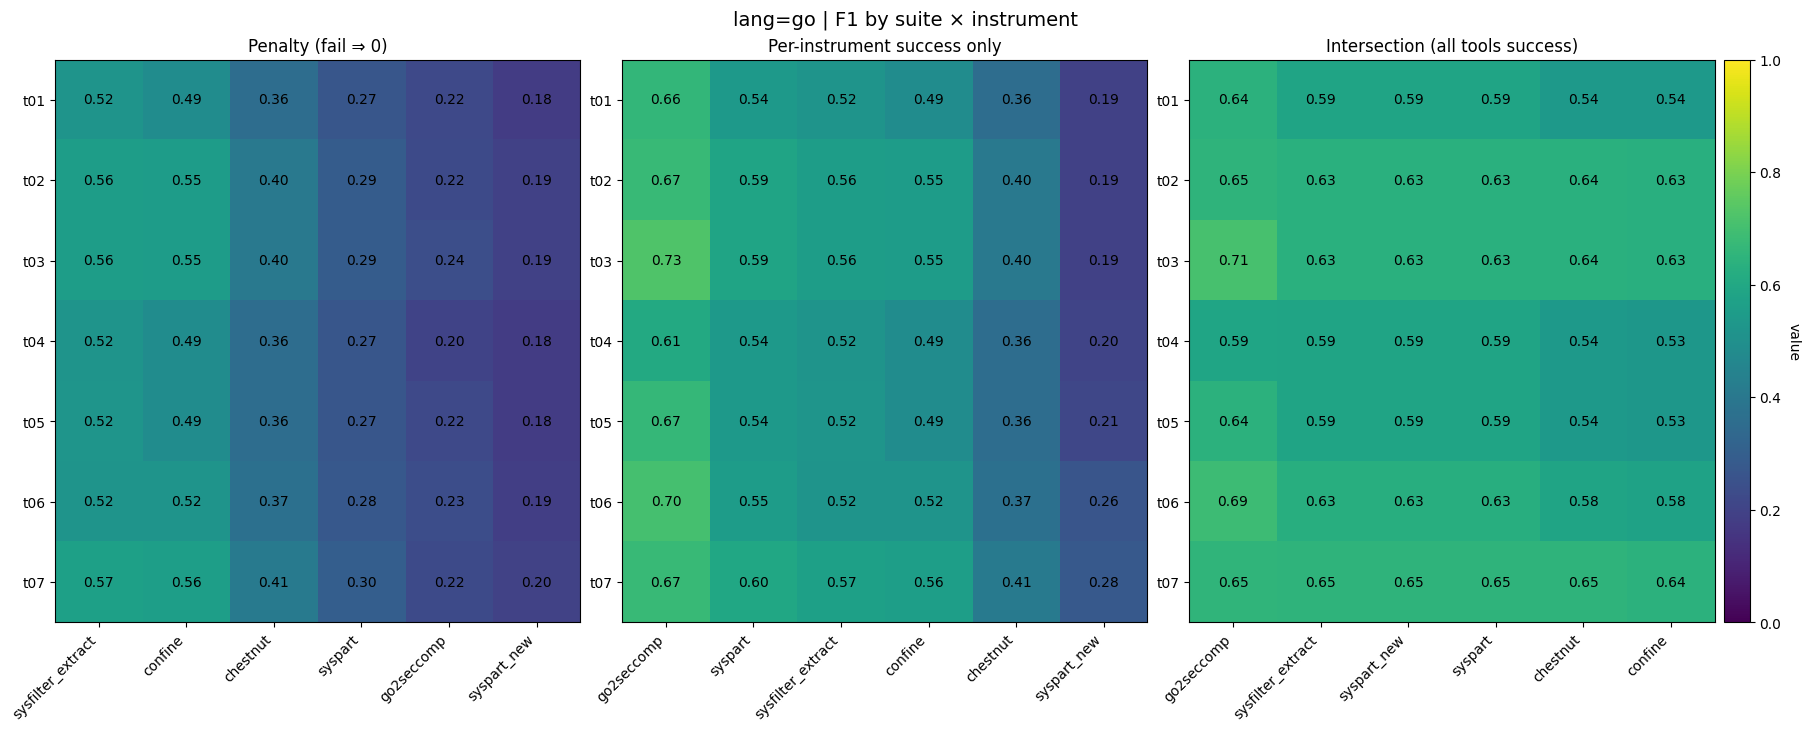

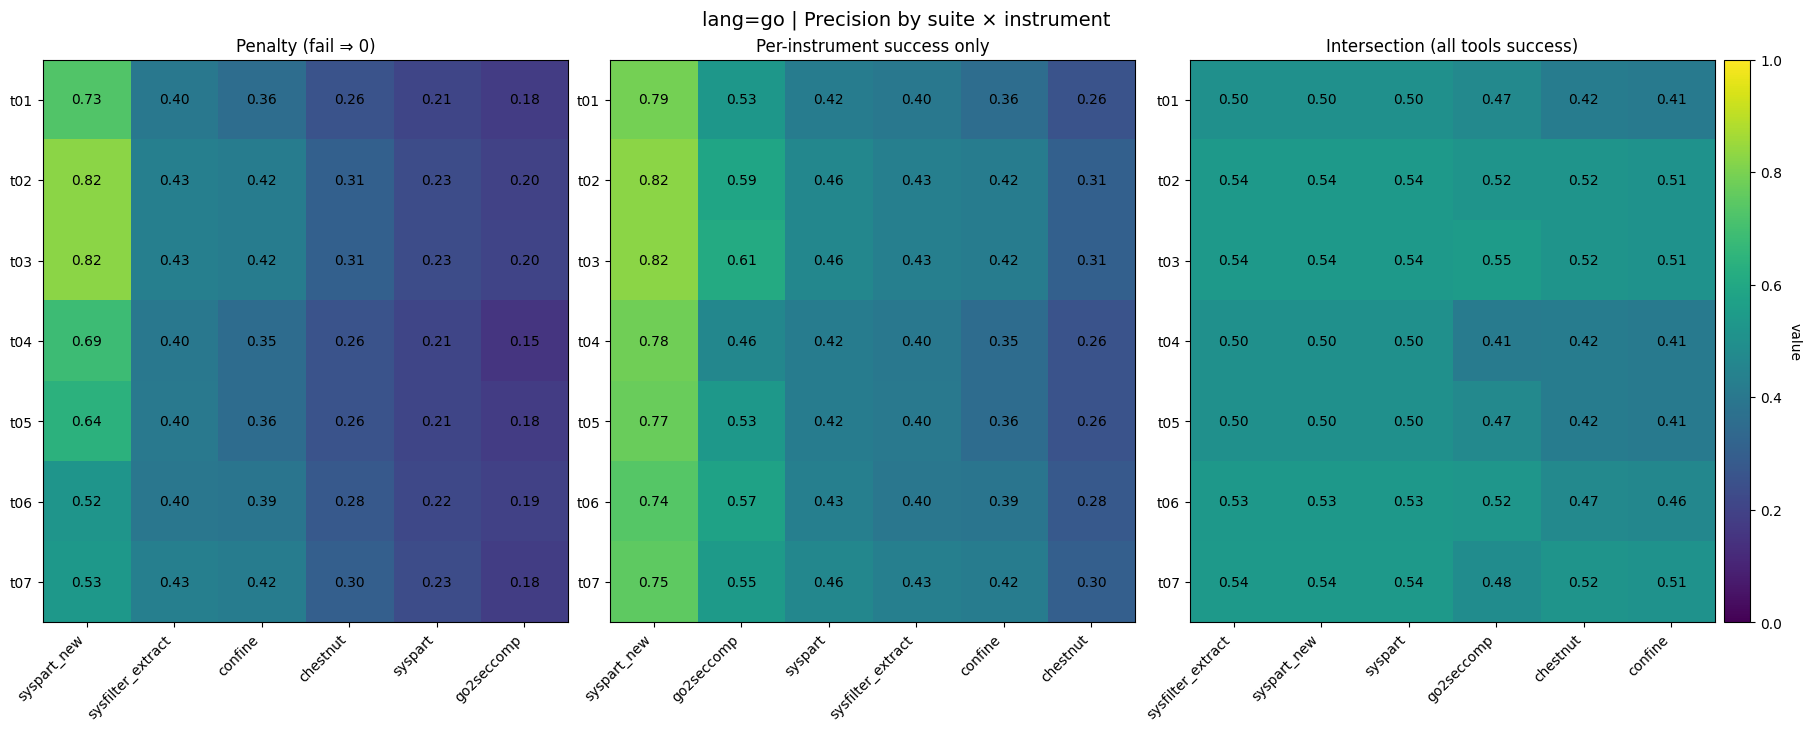

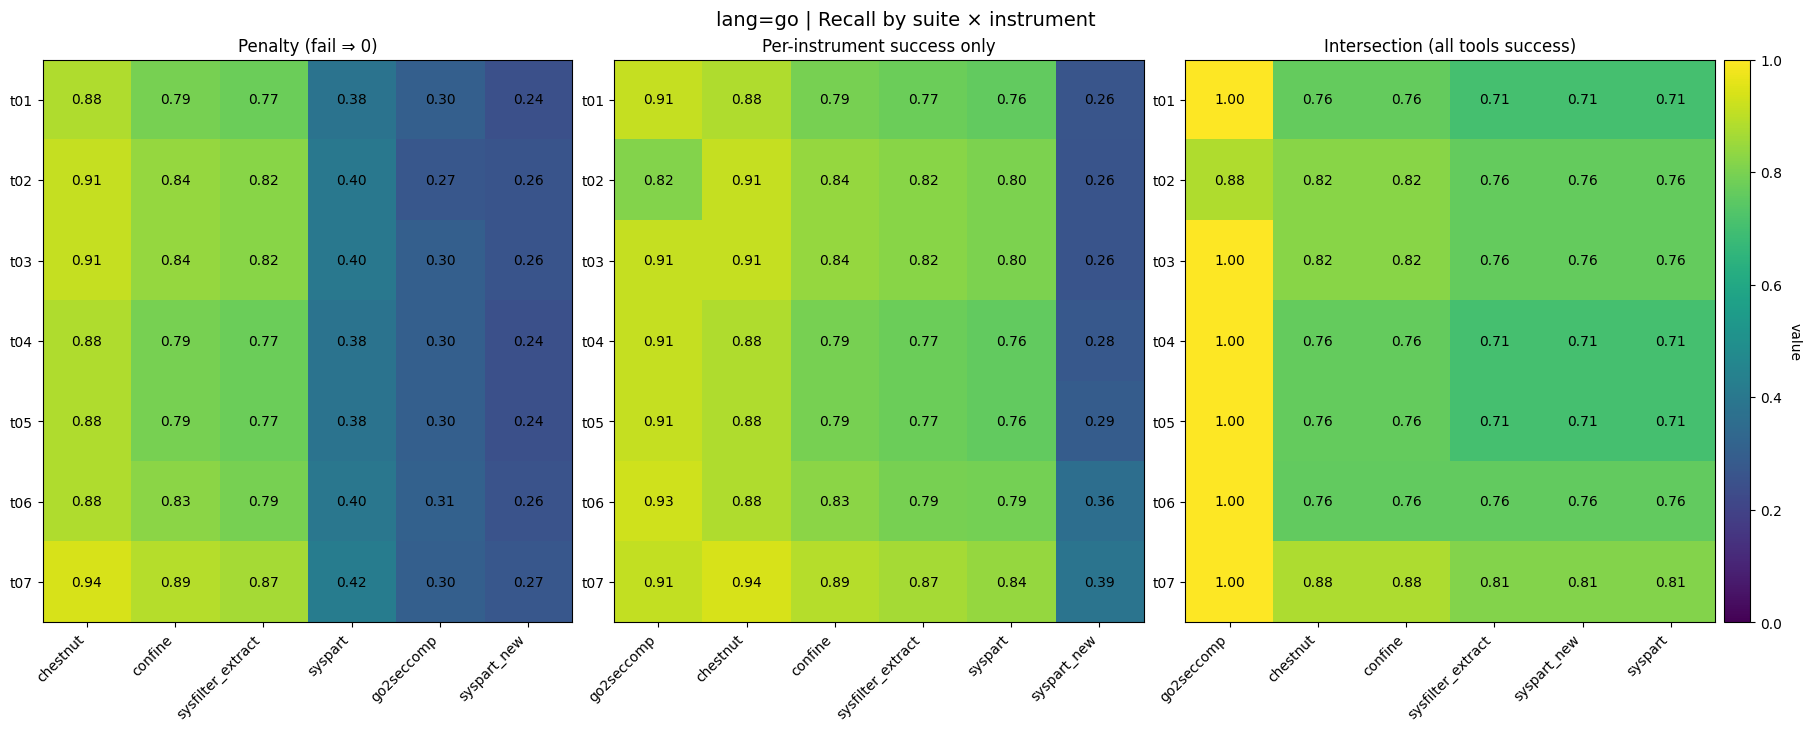

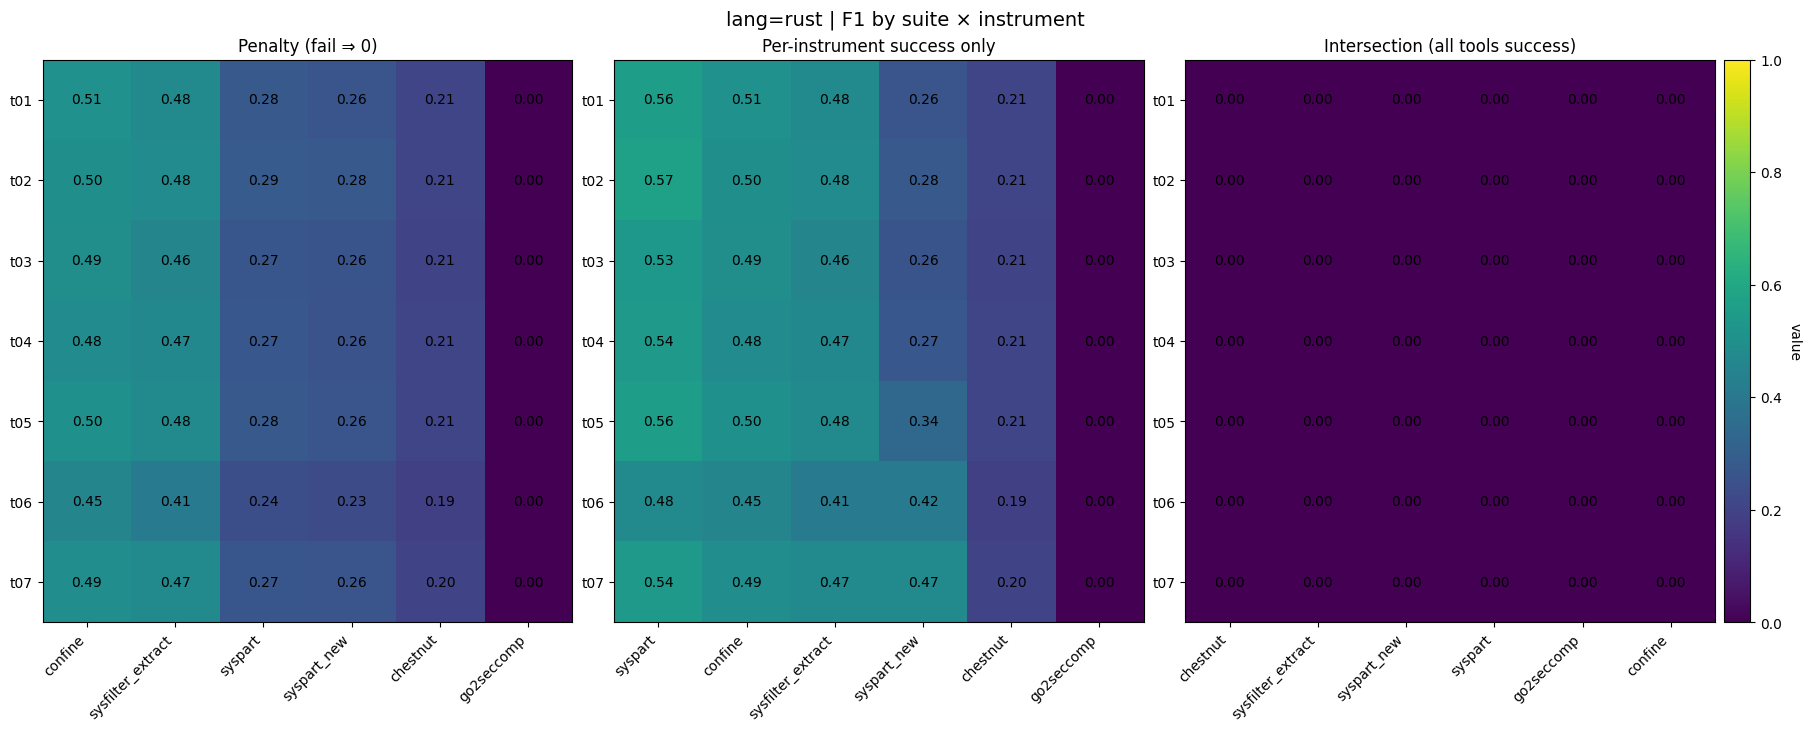

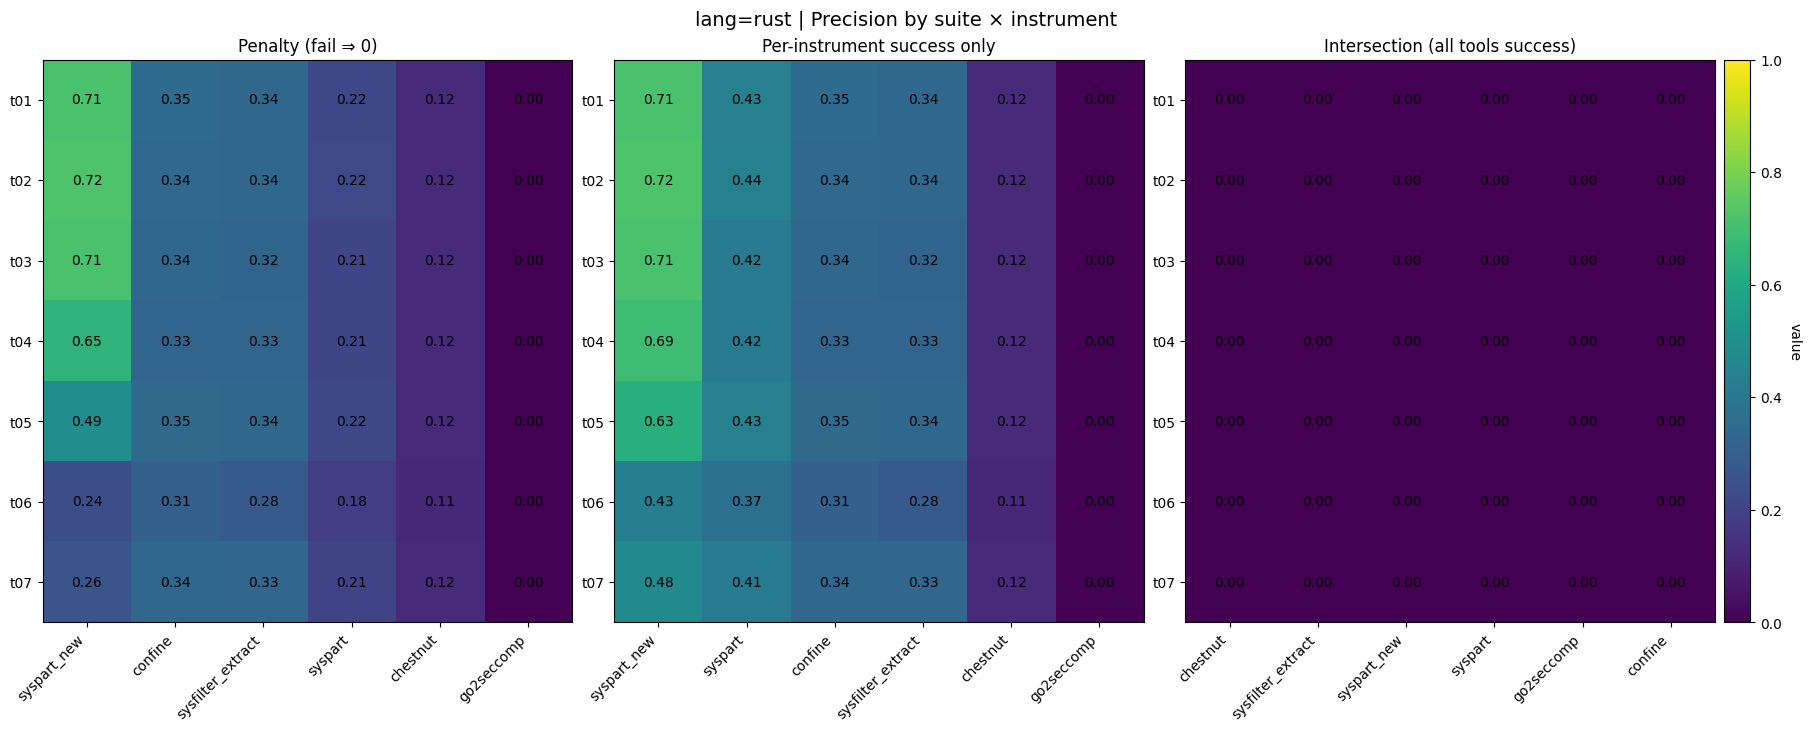

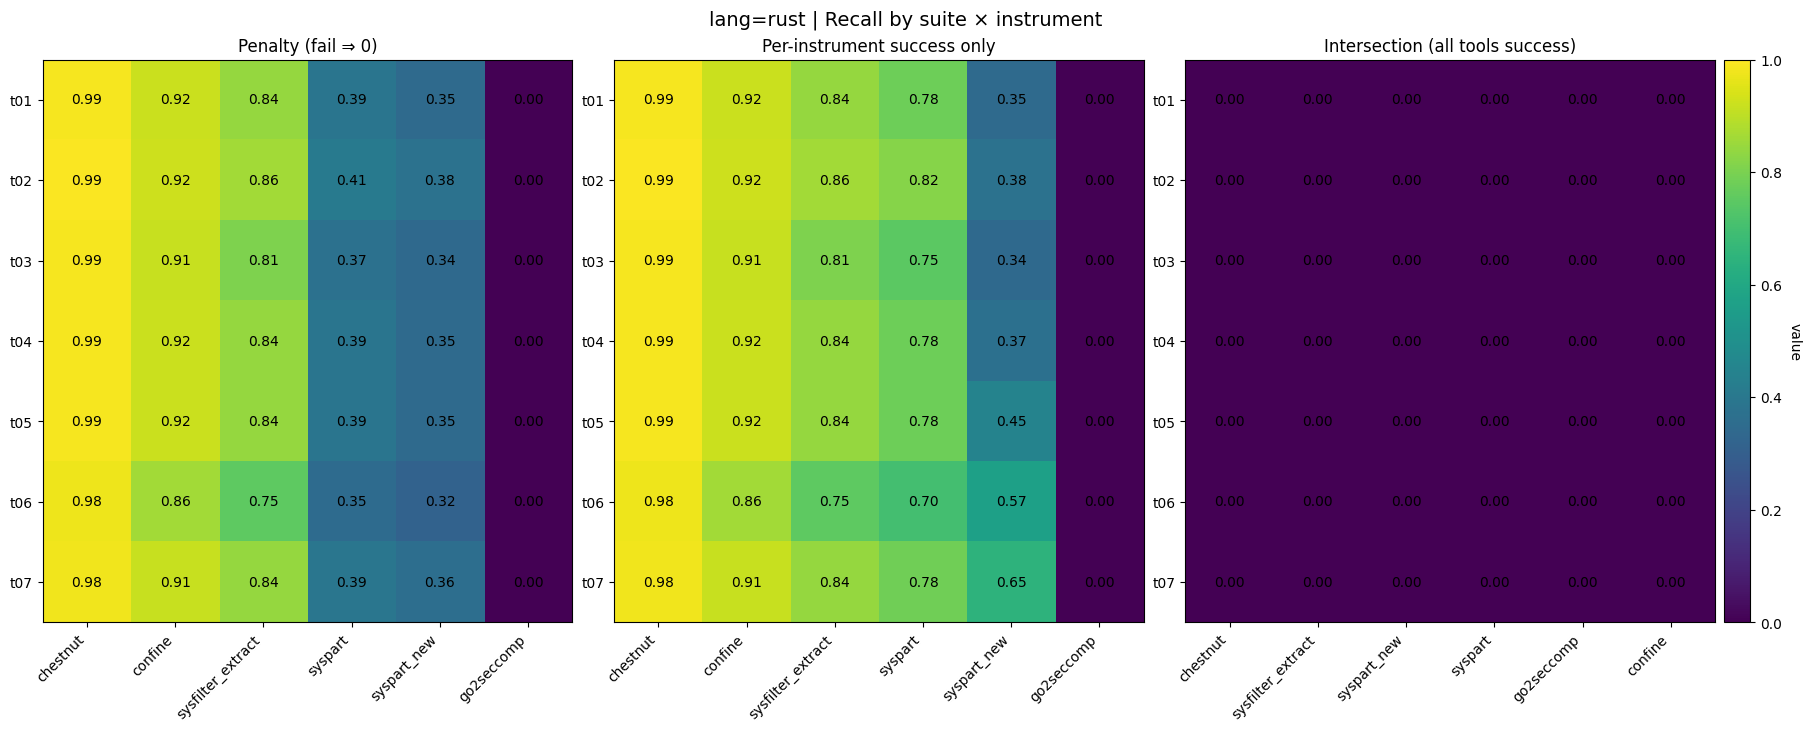

[strip] ['nostrip']


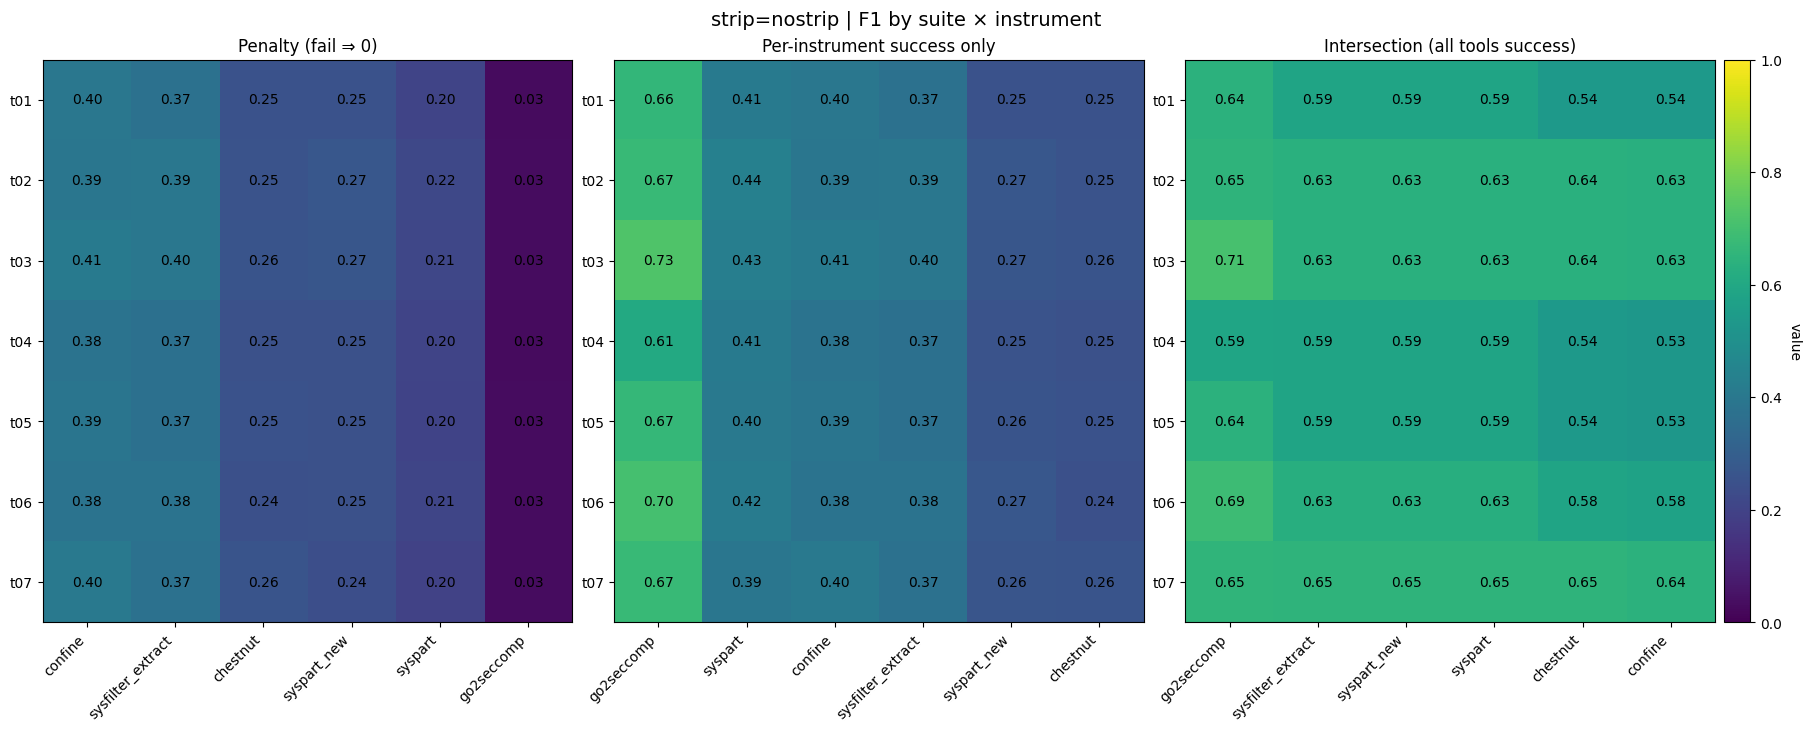

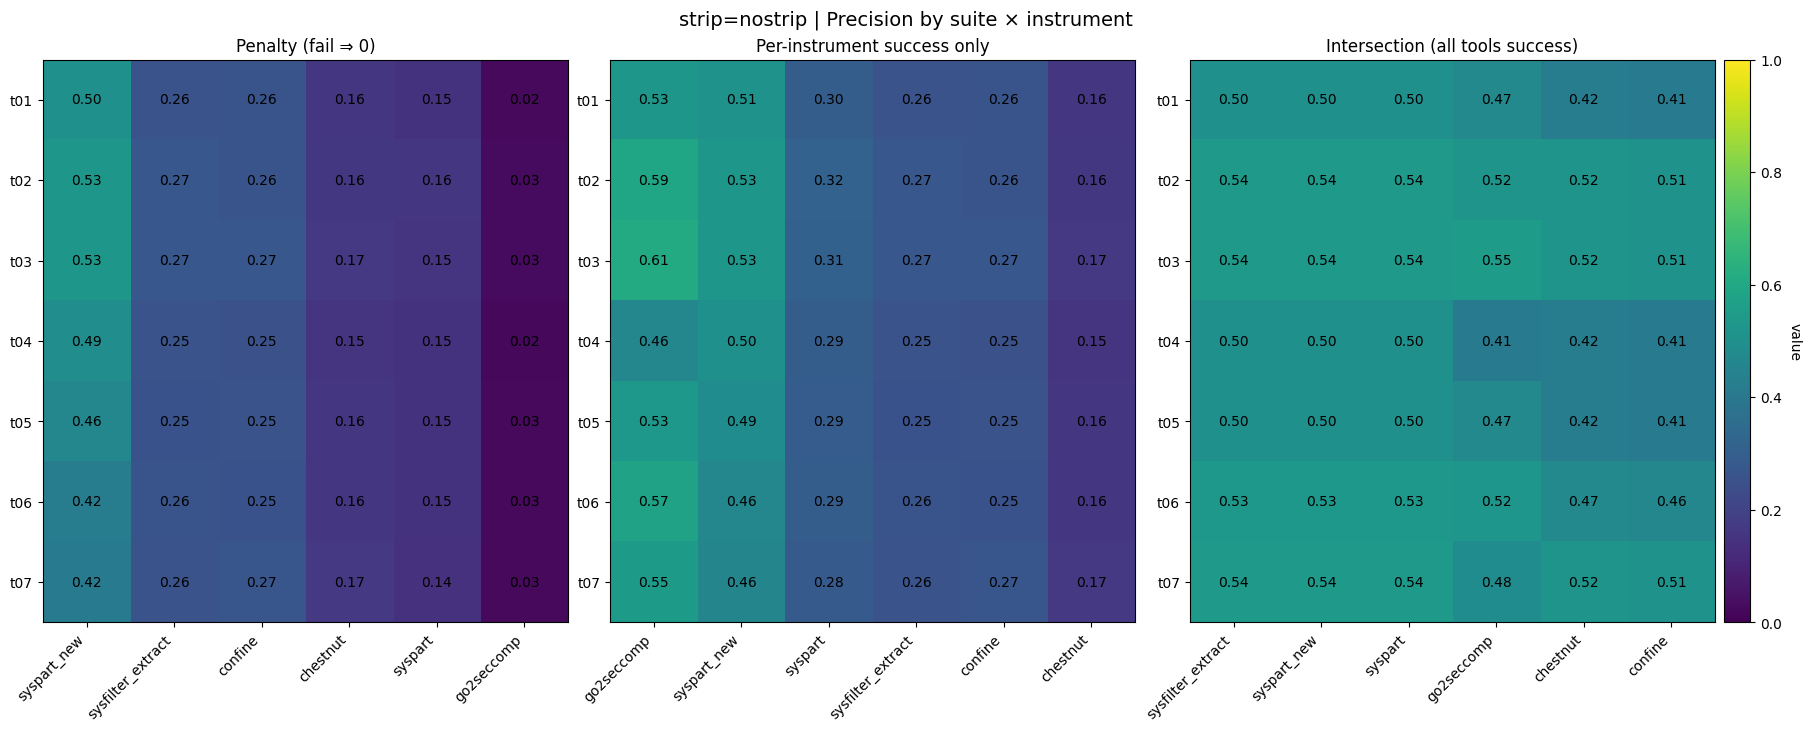

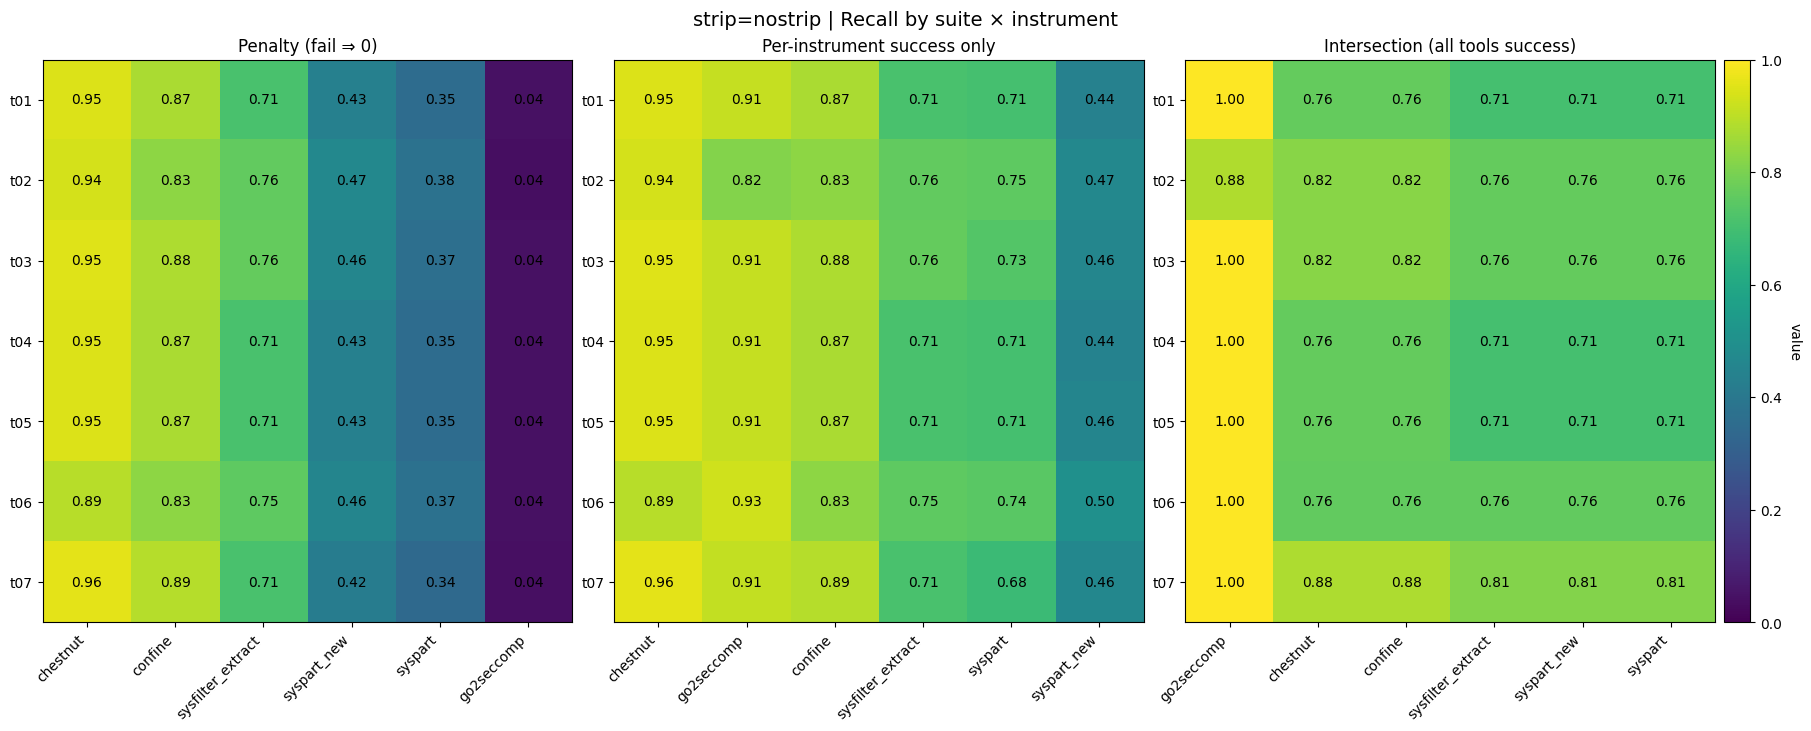

[pie_mode] ['nopie', 'pie']


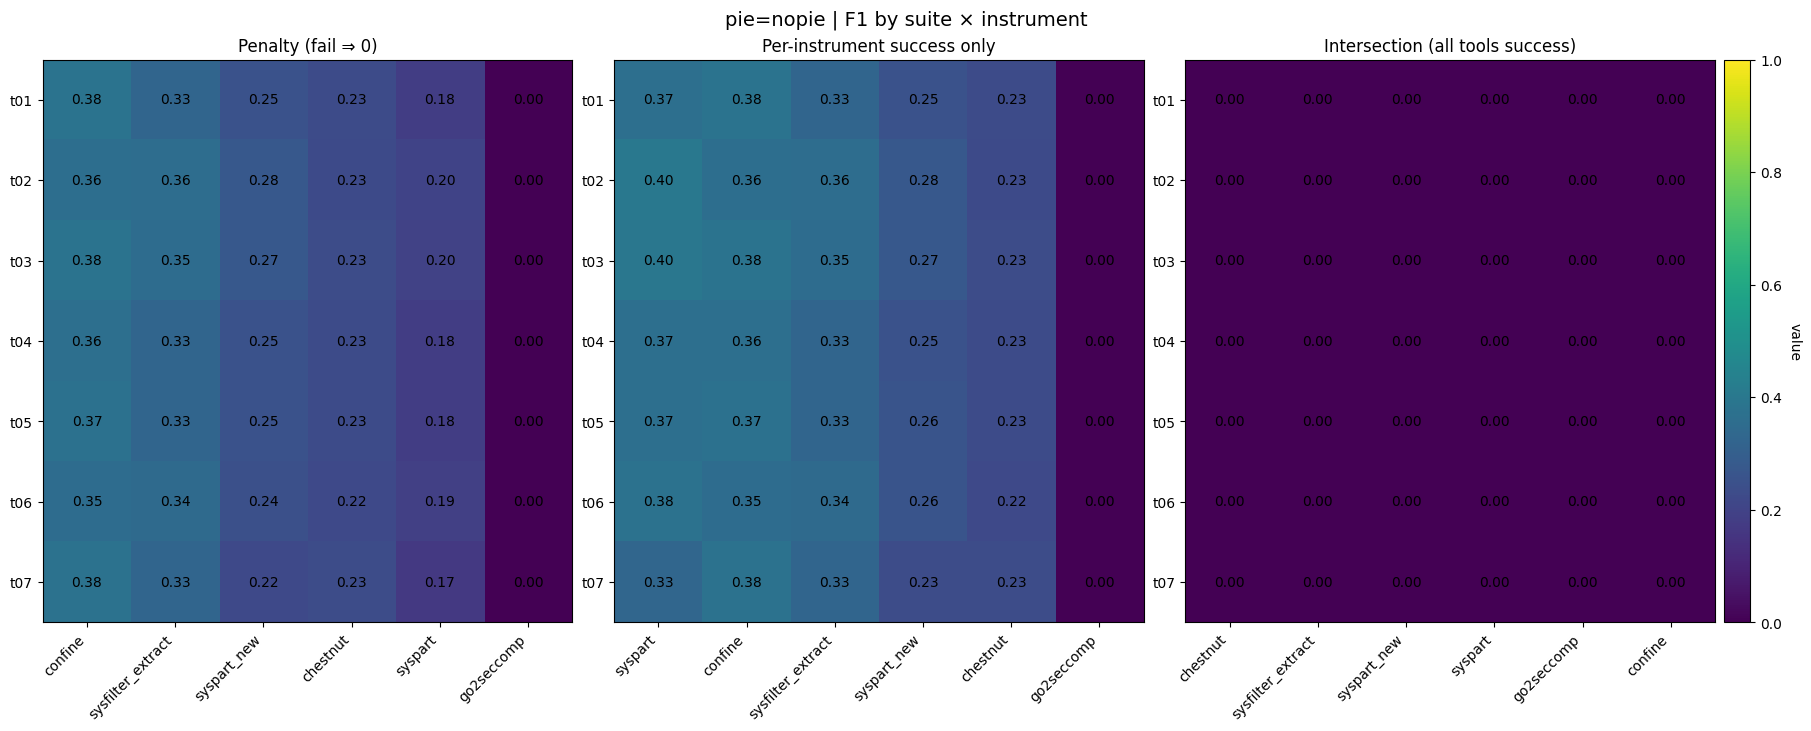

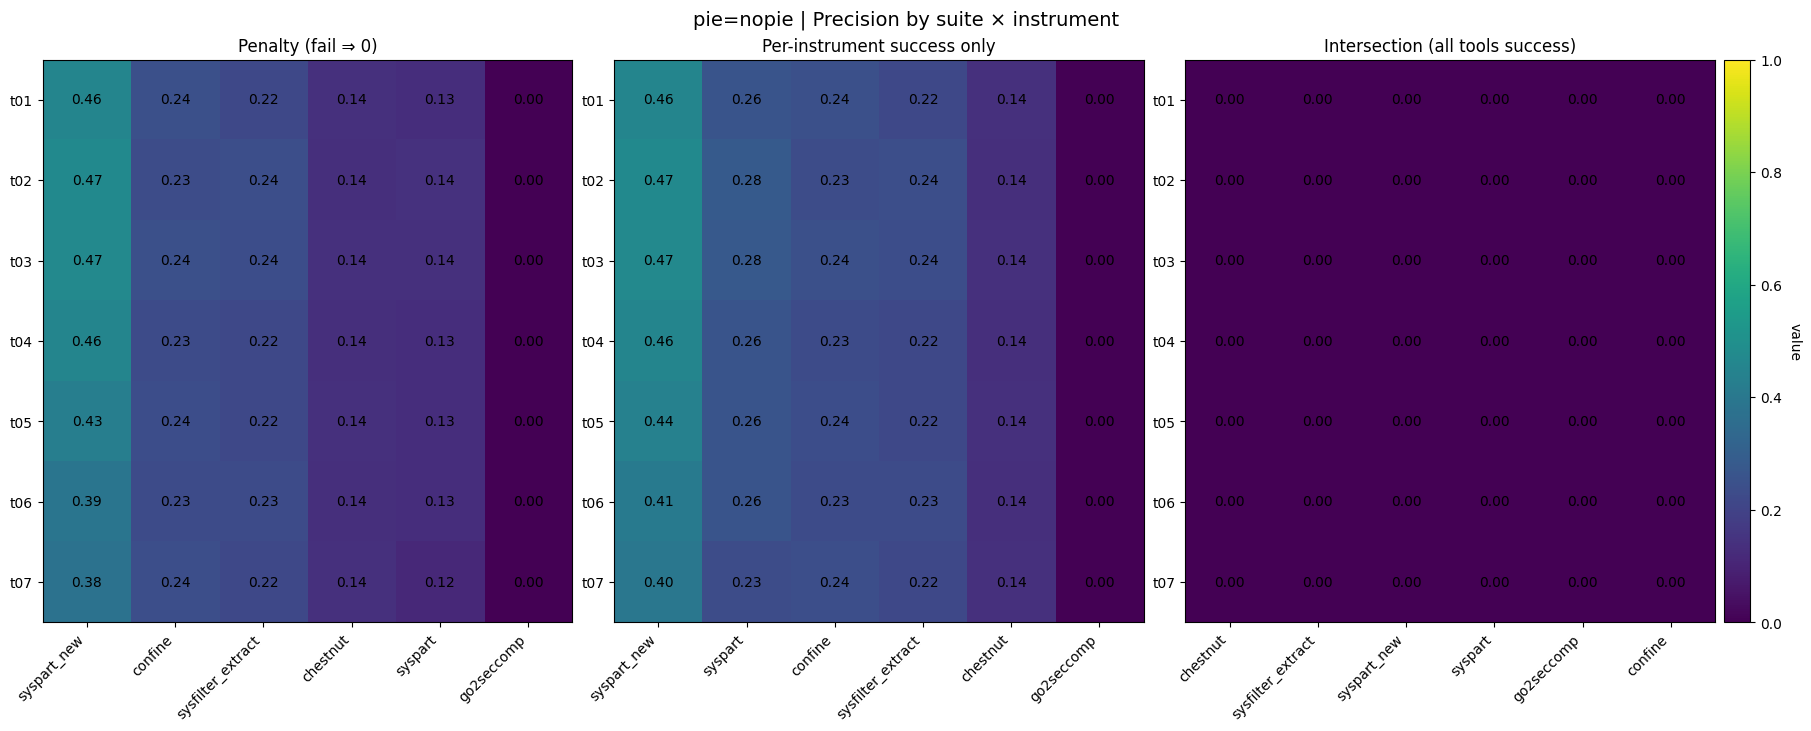

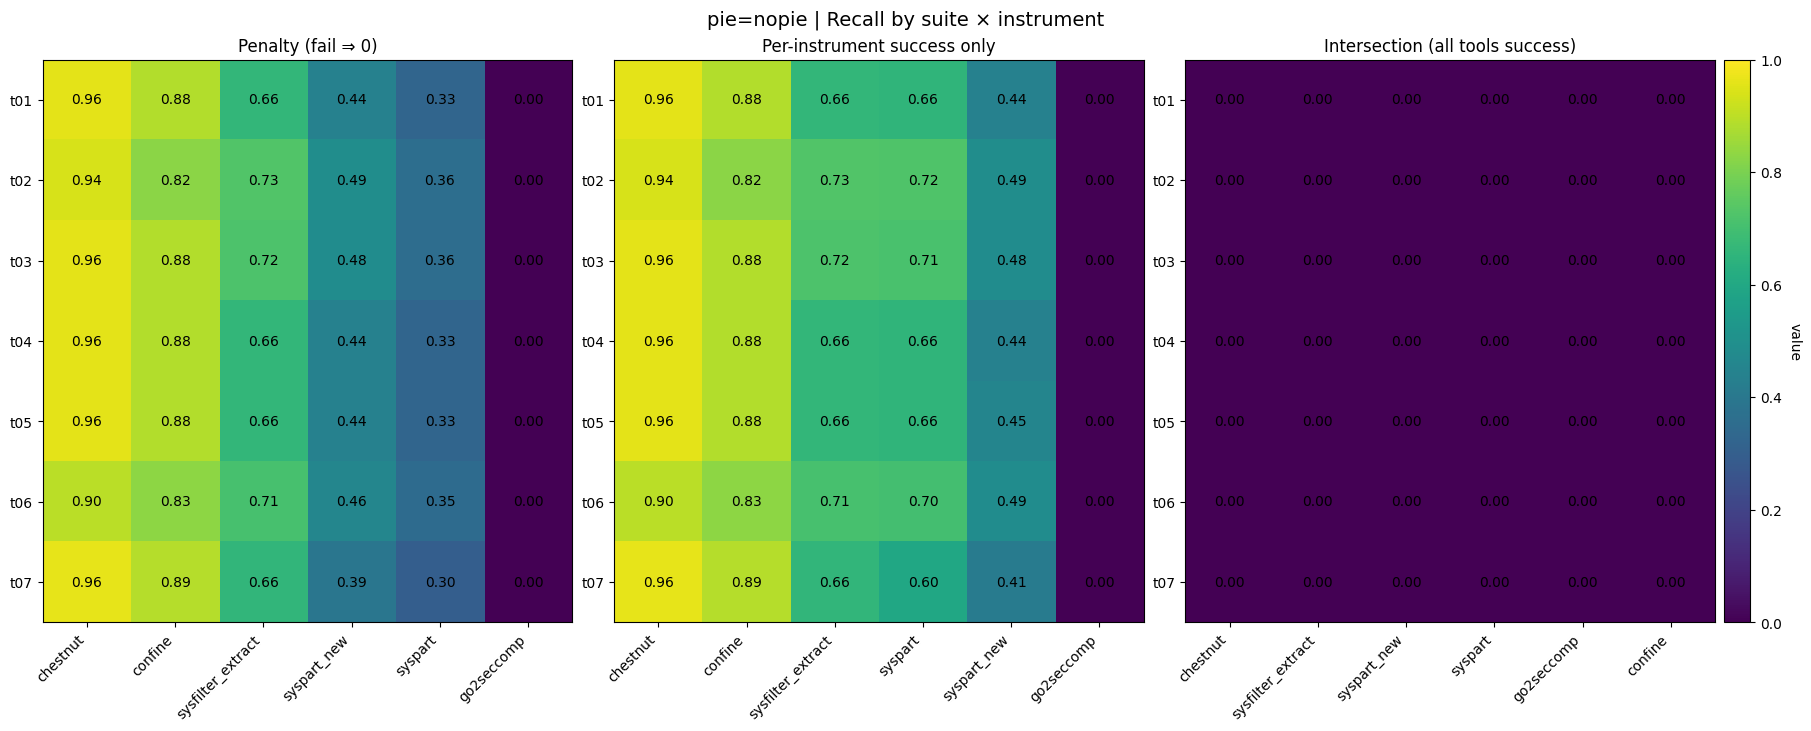

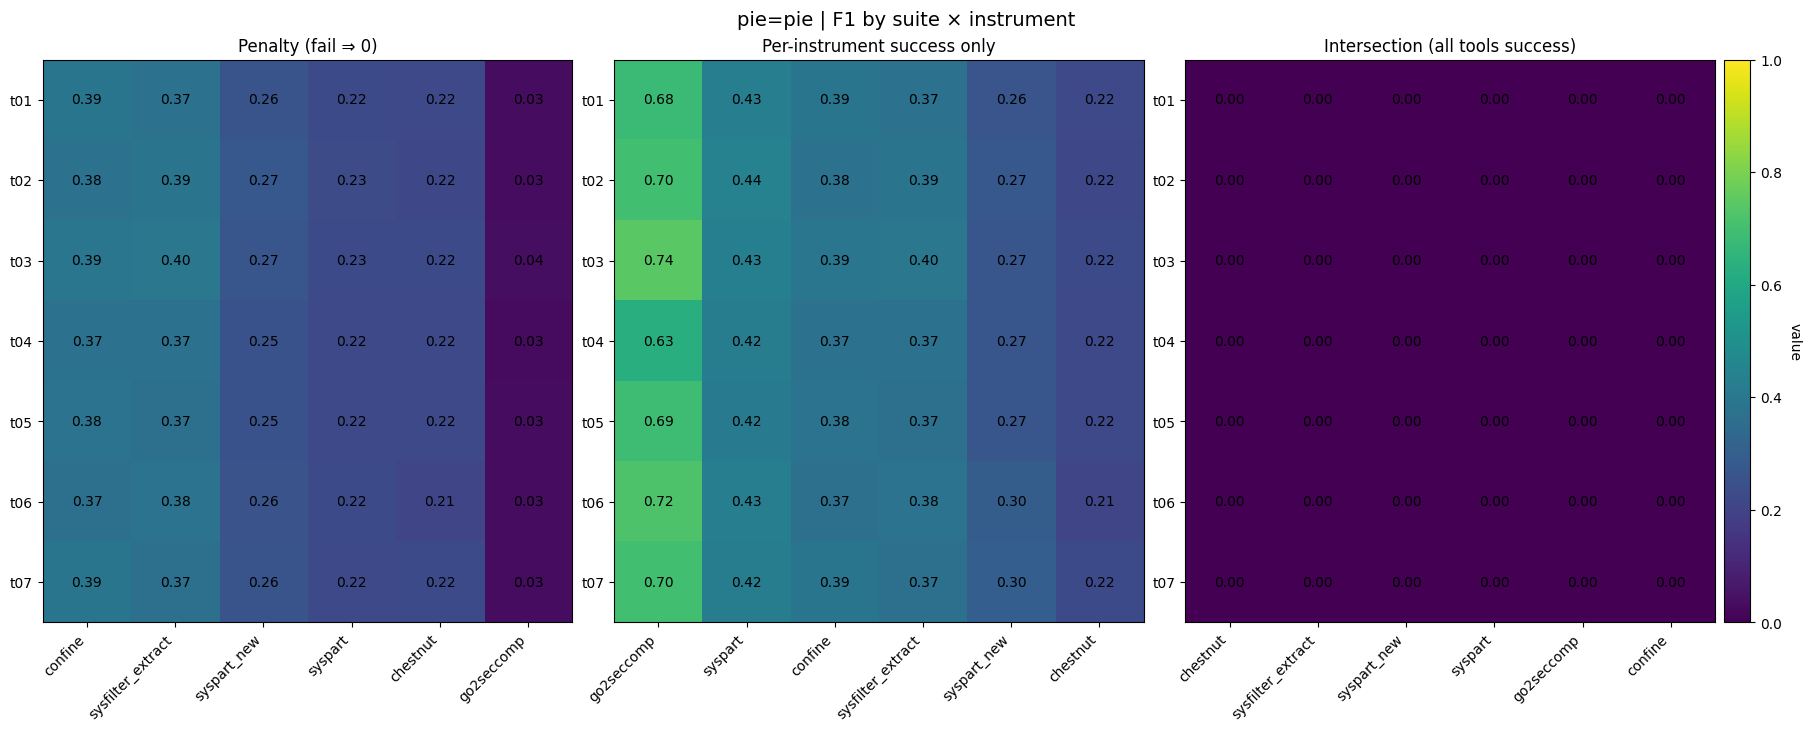

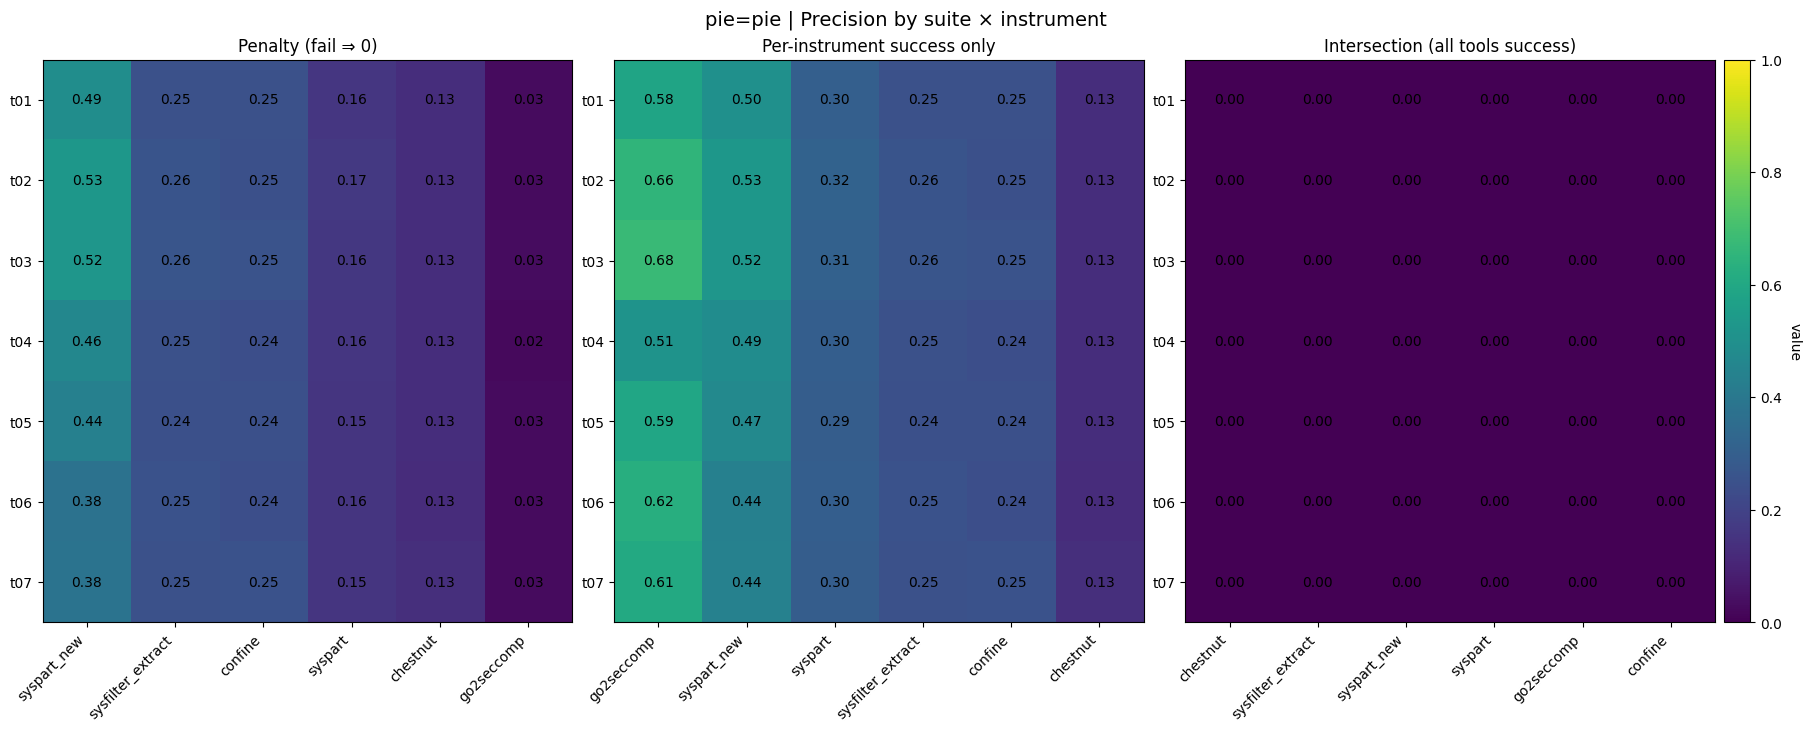

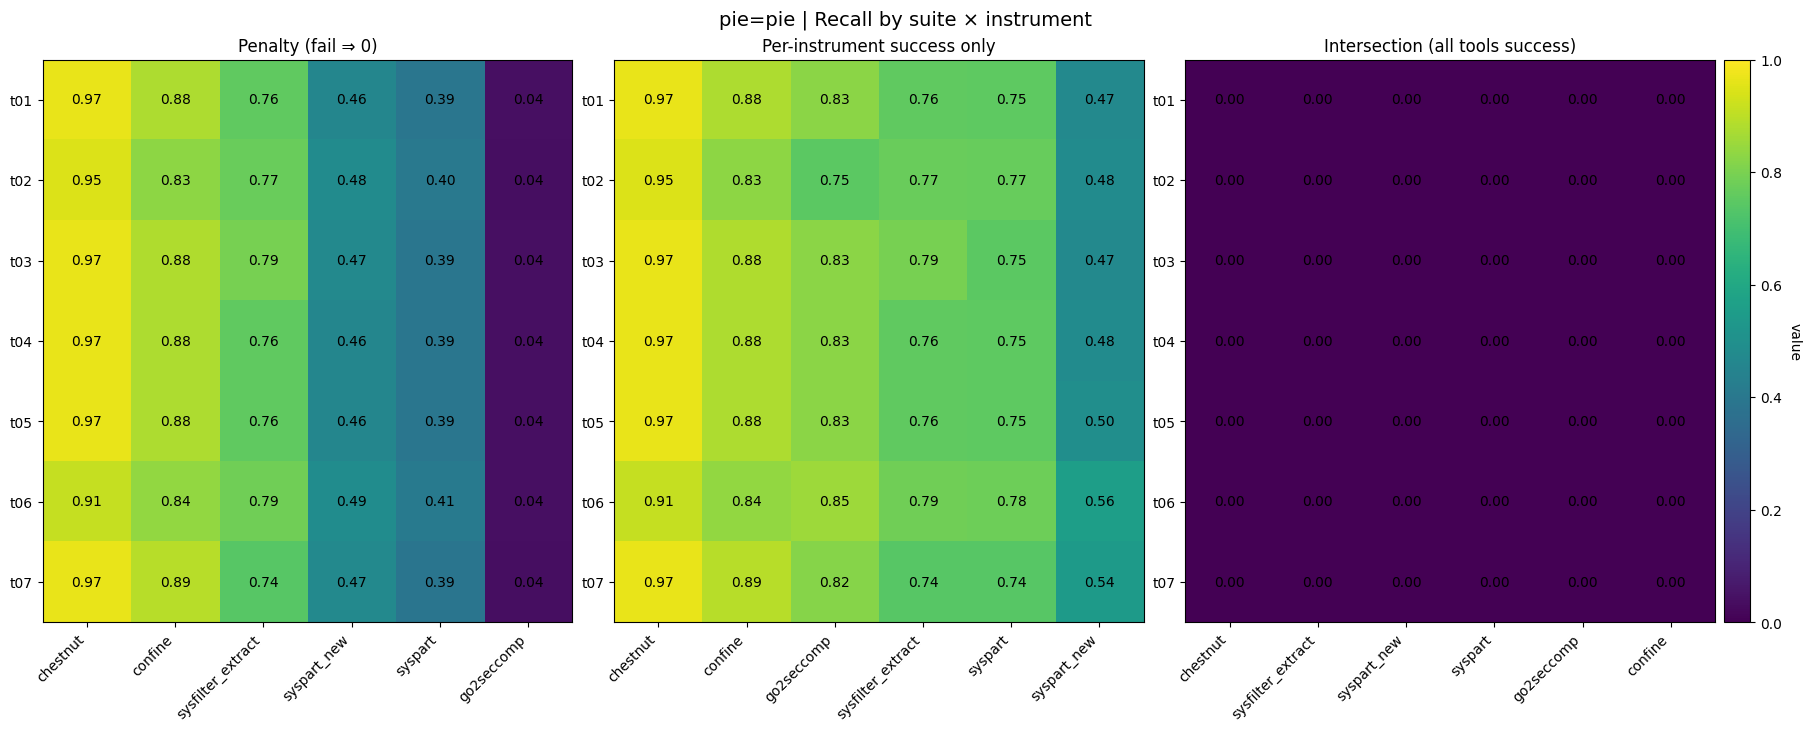

[lto_mode] ['lto', 'nolto']


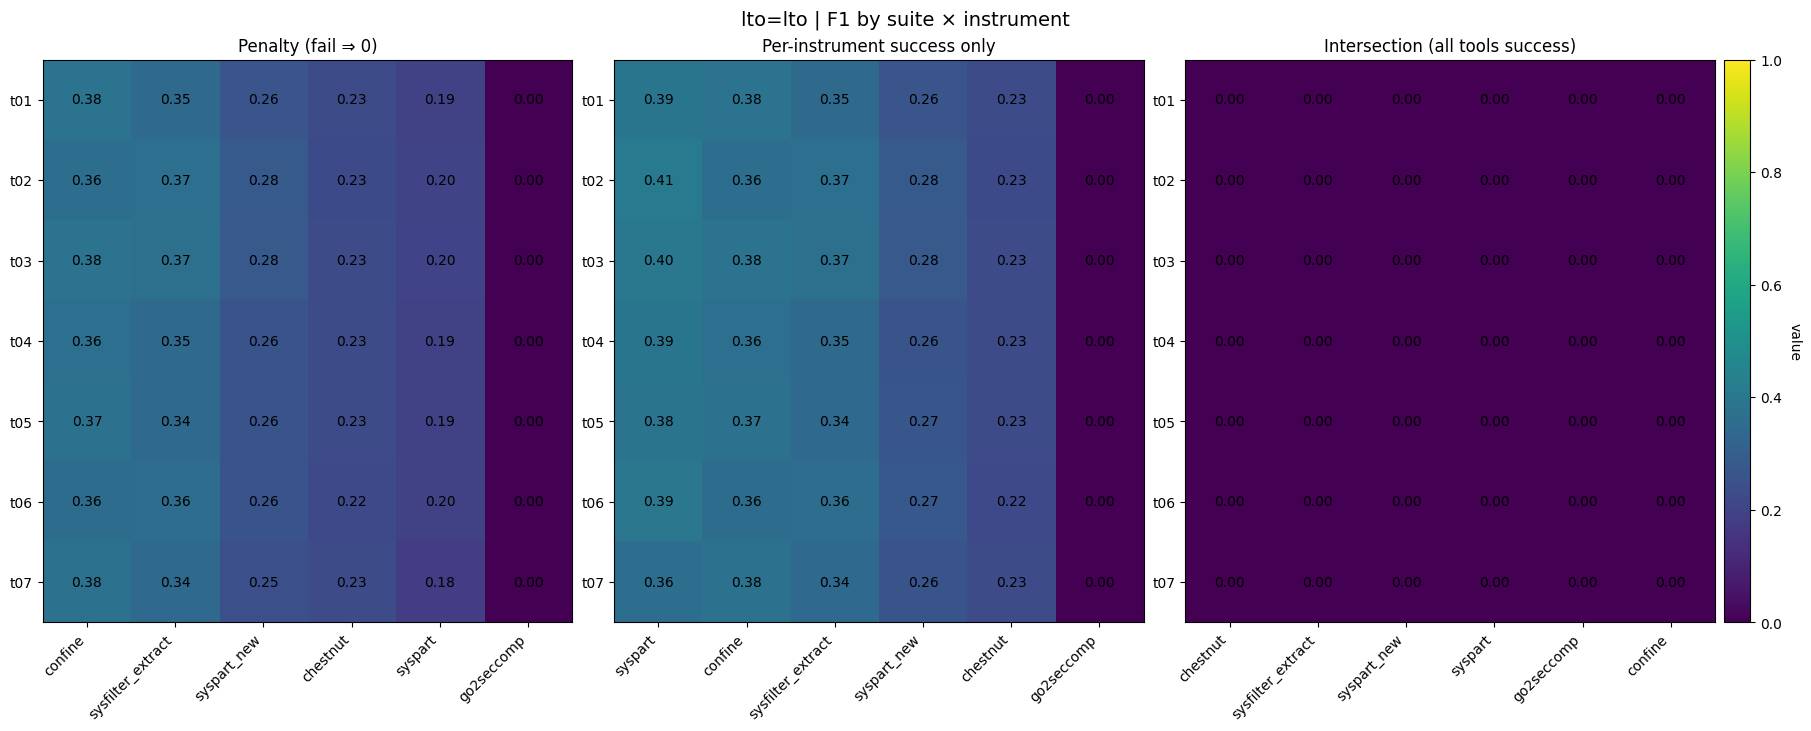

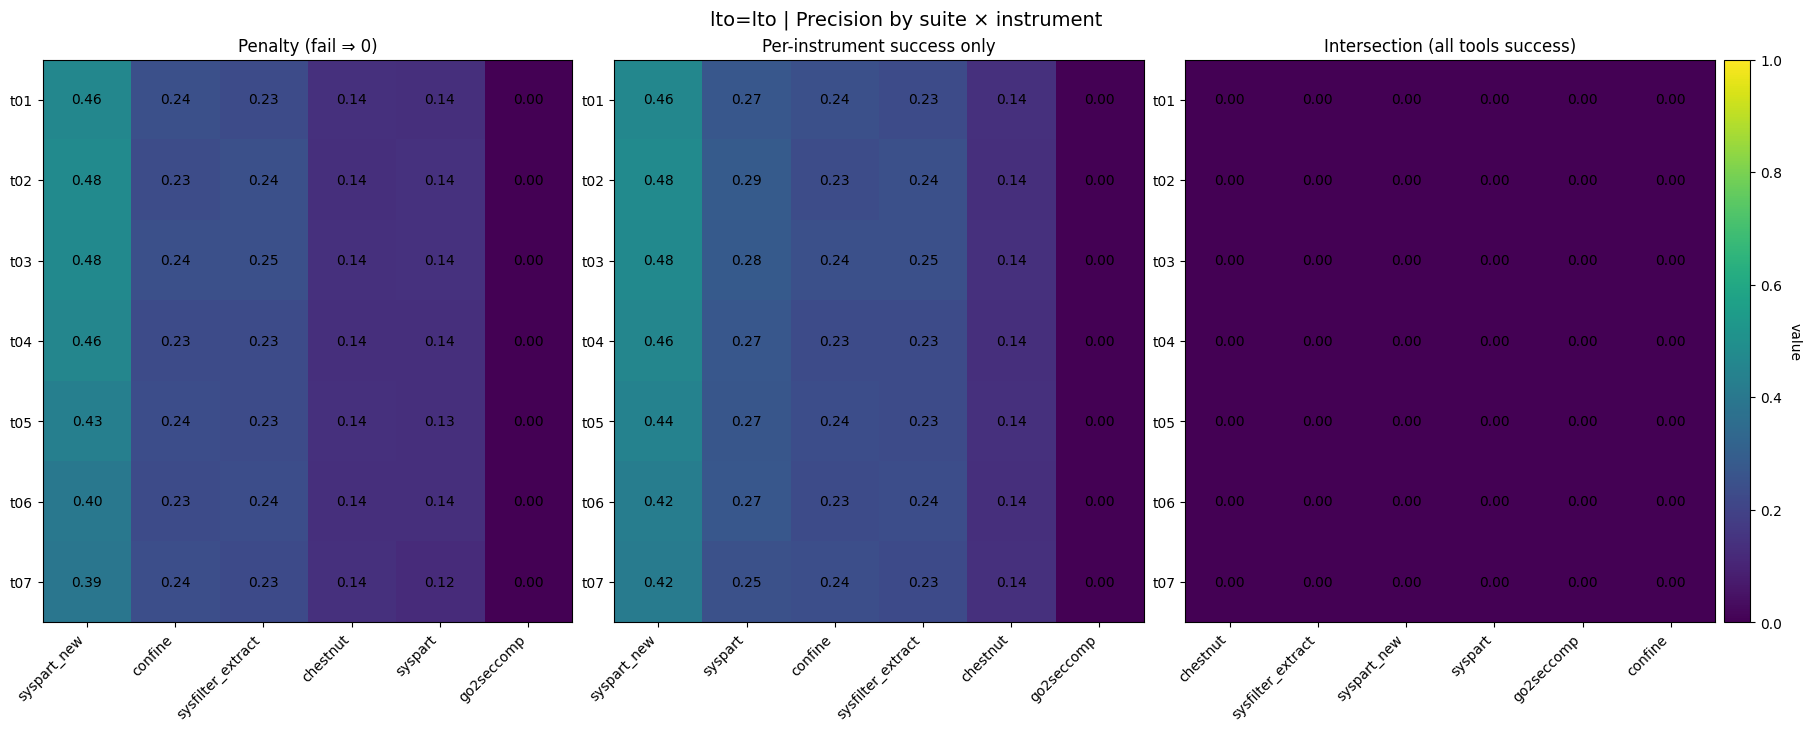

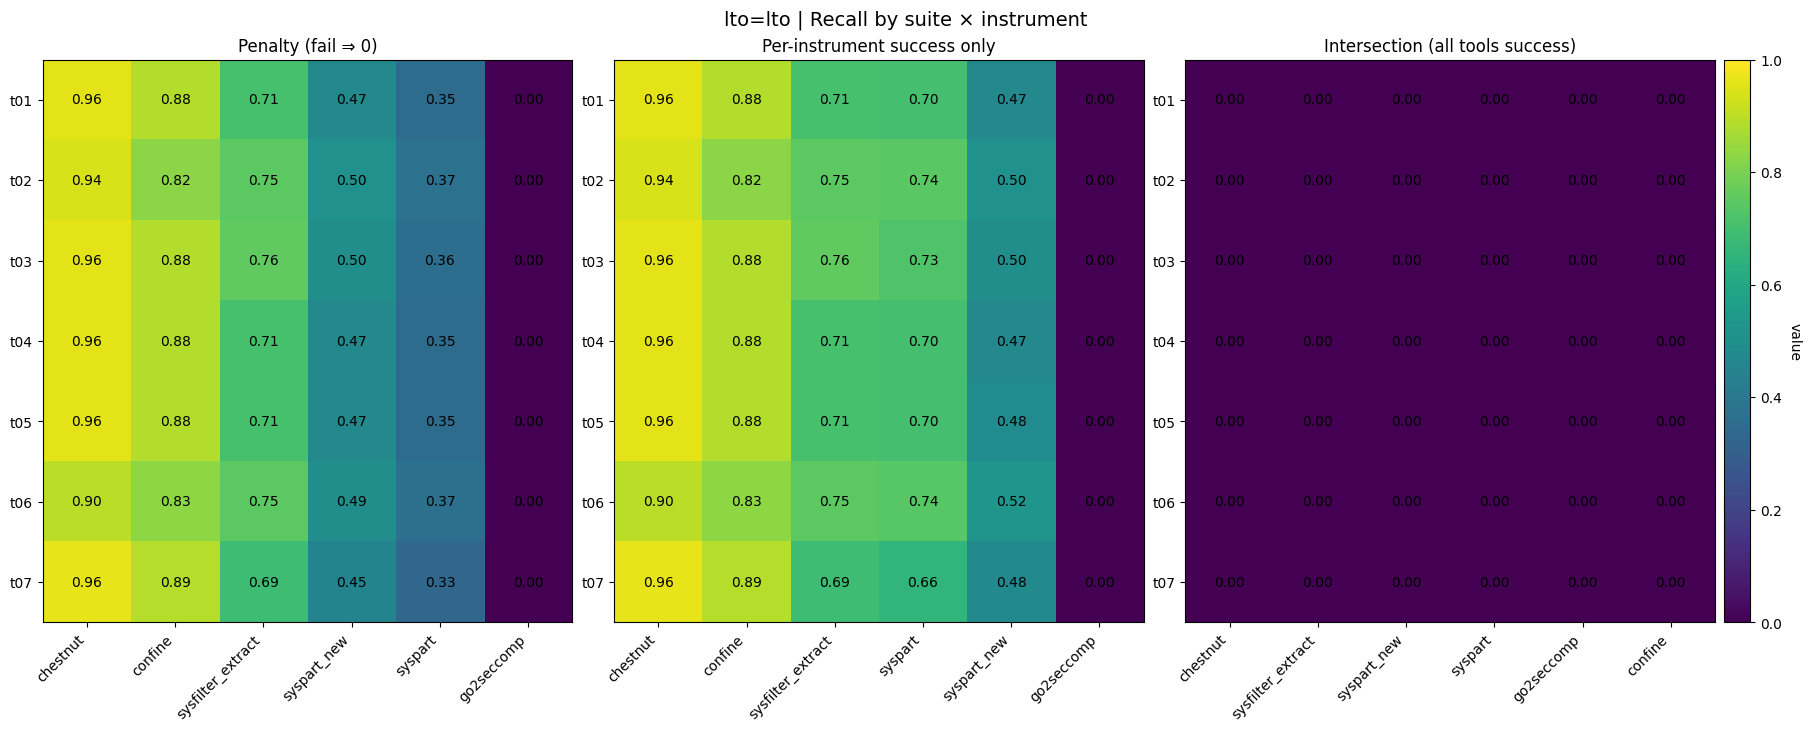

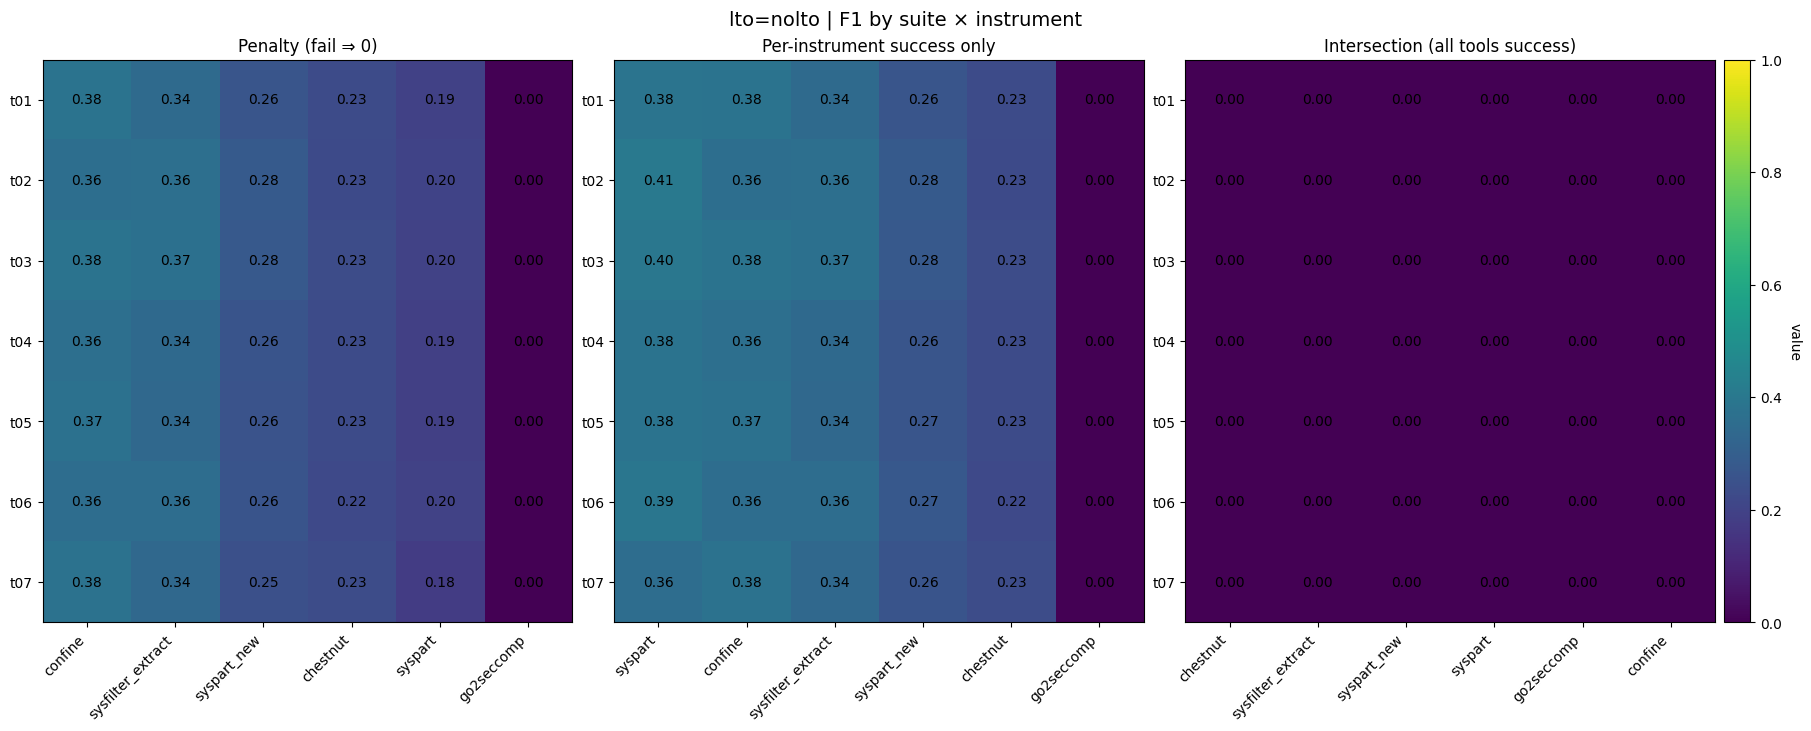

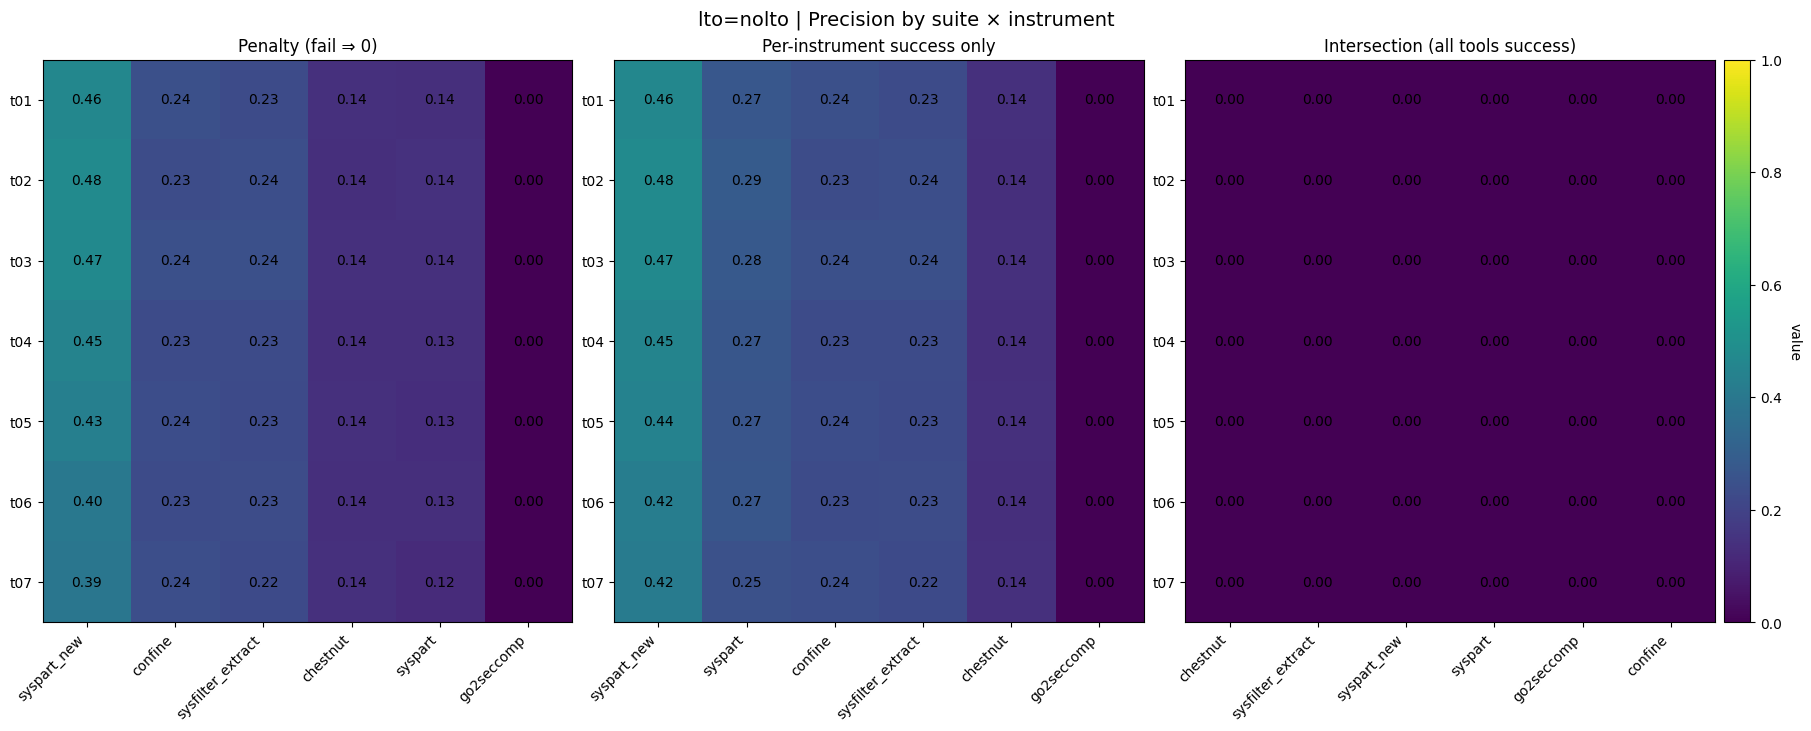

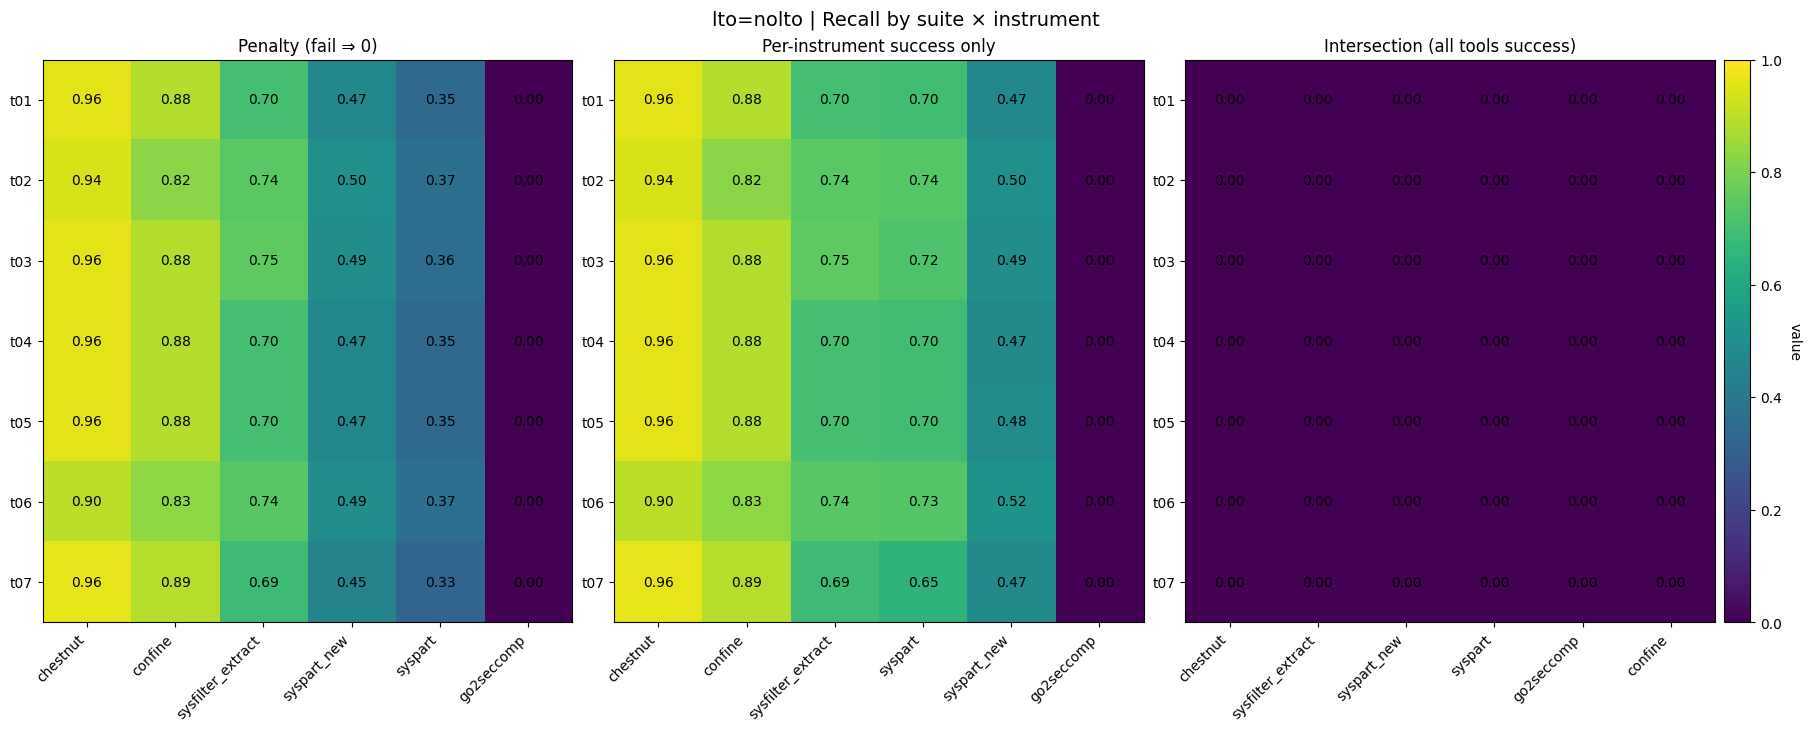

,success_rate__penalty,avg_tp__penalty,avg_fp__penalty,avg_fn__penalty,avg_tn__penalty,avg_precision__penalty,avg_recall__penalty,avg_f1__penalty,n__penalty,micro_precision__penalty,...,avg_fp__soft,avg_fn__soft,avg_tn__soft,avg_precision__soft,avg_recall__soft,avg_f1__soft,n__soft,micro_precision__soft,micro_recall__soft,micro_f1__soft
instrument,,,,,,,,,,,,,,,,,,,,,
confine,1.0000,13.9462,40.3807,2.0487,276.6244,0.2586,0.8629,0.3927,1190,0.2567,...,40.3807,2.0487,276.6244,0.2586,0.8629,0.3927,1190,0.2567,0.8719,0.3966
sysfilter_extract,1.0000,11.9882,34.2345,4.0067,282.7706,0.2606,0.7327,0.3796,1190,0.2594,...,34.2345,4.0067,282.7706,0.2606,0.7327,0.3796,1190,0.2594,0.7495,0.3854
chestnut,1.0000,15.2168,151.2387,0.7782,165.7664,0.1599,0.9402,0.2531,1190,0.0914,...,151.2387,0.7782,165.7664,0.1599,0.9402,0.2531,1190,0.0914,0.9514,0.1668
syspart_new,0.9630,7.0908,19.2756,7.9882,298.6454,0.4789,0.4441,0.2531,1190,0.2689,...,20.0157,8.2949,297.3264,0.4973,0.4611,0.2628,1146,0.2689,0.4702,0.3422
syspart,0.5000,5.9235,14.0462,2.1697,310.8605,0.1487,0.3590,0.2069,1190,0.2966,...,28.0924,4.3395,288.7210,0.2974,0.7180,0.4137,595,0.2966,0.7319,0.4222
go2seccomp,0.0471,0.8706,0.7294,0.1160,331.2840,0.0258,0.0424,0.0317,1190,0.5441,...,15.5000,2.4643,296.5357,0.5487,0.9008,0.6738,56,0.5441,0.8825,0.6732


,runs,success,fail,success_rate
instrument,,,,
confine,1190,1190,0,1.0000
sysfilter_extract,1190,1190,0,1.0000
chestnut,1190,1190,0,1.0000
syspart_new,1190,1146,44,0.9630
syspart,1190,595,595,0.5000
go2seccomp,1190,56,1134,0.0471


,instrument,exit_code,count
0,confine,0,1190
1,sysfilter_extract,0,1190
2,chestnut,0,1190
3,syspart_new,0,1146
4,syspart_new,134,28
5,syspart_new,124,16
6,syspart,0,595
7,syspart,139,567
8,syspart,124,28
9,go2seccomp,1,1134


In [4]:
WORKSPACE_PATH = "build/workspace"
INSTRUMENTS = list(INSTRUMENT_PREFIXES)

def normalize_instrument(name: str) -> str:
    return "sysfilter_extract" if name == "sysfilter" else name

ALL_SYSCALLS = set(SYSCALL_MAP.values())
UNIVERSE_N = len(ALL_SYSCALLS)

def load_workspace_all(workspace_path: str, syscall_map: dict):
    base_dir = os.path.join(workspace_path, "syscall_results")
    files = glob.glob(os.path.join(base_dir, "**", "*"), recursive=True)
    files = [p for p in files if os.path.isfile(p)]
    files = [p for p in files if "opt__test__build__" in p]

    pred_sets = {}
    exit_codes = {}

    for p in files:
        tail = p.split("__")[-1]
        if "/" not in tail:
            continue
        test_name, fname = tail.split("/", 1)

        if fname.endswith(".exitcode"):
            inst = normalize_instrument(fname.removesuffix(".exitcode"))
            try:
                with open(p, "r") as f:
                    line = next((x for x in f.read().splitlines() if x.strip()), None)
                if line is not None:
                    exit_codes[(test_name, inst)] = int(line.strip())
            except Exception:
                exit_codes[(test_name, inst)] = 999
            continue

        if fname.endswith(".syscalls.json"):
            inst = normalize_instrument(fname.split(".", 1)[0])
            try:
                with open(p, "r") as f:
                    nums = json.load(f)
                nums = [int(x) for x in nums]
                pred_sets[(test_name, inst)] = set(syscall_map.get(n, "unknown") for n in nums)
            except Exception:
                pred_sets[(test_name, inst)] = set()
            continue

        if fname.endswith(".syscalls.txt"):
            inst = normalize_instrument(fname.split(".", 1)[0])
            try:
                with open(p, "r") as f:
                    pred_sets[(test_name, inst)] = set(x for x in f.read().splitlines() if x.strip())
            except Exception:
                pred_sets[(test_name, inst)] = set()
            continue

    return pred_sets, exit_codes, len(files)

pred_sets, exit_codes, scanned_n = load_workspace_all(WORKSPACE_PATH, SYSCALL_MAP)
print(f"[scan] files scanned: {scanned_n}")
print(f"[scan] pred_sets pairs: {len(pred_sets)} | exit_codes pairs: {len(exit_codes)}")

def counts(valid_set, pred_set):
    valid_set = set(valid_set or [])
    pred_set = set(pred_set or [])
    tp = len(valid_set & pred_set)
    fp = len(pred_set - valid_set)
    fn = len(valid_set - pred_set)
    return tp, fp, fn

def prf(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) else 1.0
    recall = tp / (tp + fn) if (tp + fn) else 1.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 1.0
    return precision, recall, f1

def extract_option(test_name: str, idx: int) -> str:
    parts = test_name.split("_")
    return parts[idx] if len(parts) > idx else "unknown"

KNOWN_LANGS = {"c", "cpp", "go", "rust"}

def extract_lang(test_name: str) -> str:
    parts = test_name.split("_")
    for p in parts:
        if p in KNOWN_LANGS:
            return p
    return "unknown"

def extract_strip(test_name: str) -> str:
    return "strip" if "_strip" in test_name.split("_") else "nostrip"

def extract_pie(test_name: str) -> str:
    parts = set(test_name.split("_"))
    if "nopie" in parts:
        return "nopie"
    if "pie" in parts:
        return "pie"
    return "unknown"

def extract_lto(test_name: str) -> str:
    parts = set(test_name.split("_"))
    if "nolto" in parts:
        return "nolto"
    if "lto" in parts:
        return "lto"
    return "unknown"

tests = sorted(build_syscalls.keys())
rows = []

for test_name in tests:
    suite = test_name.split("_", 1)[0]
    valid = build_syscalls[test_name]

    for inst in INSTRUMENTS:
        code = exit_codes.get((test_name, inst), None)
        success = (code == 0)

        if success:
            pred = pred_sets.get((test_name, inst), set())
            tp, fp, fn = counts(valid, pred)
            precision, recall, f1 = prf(tp, fp, fn)
        else:
            tp = fp = fn = 0
            precision = recall = f1 = np.nan

        tn = UNIVERSE_N - tp - fp - fn
        if tn < 0:
            tn = 0

        rows.append({
            "suite": suite,
            "test": test_name,
            "instrument": inst,
            "exit_code": code,
            "success": success,
            "tp": tp, "fp": fp, "fn": fn, "tn": tn,
            "precision": precision, "recall": recall, "f1": f1,
            "lang": extract_lang(test_name),
            "strip": extract_strip(test_name),
            "pie_mode": extract_pie(test_name),
            "lto_mode": extract_lto(test_name),
            "compiler": extract_option(test_name, 3),
            "opt": extract_option(test_name, 4),
            "lto": extract_option(test_name, 5),
            "pie": extract_option(test_name, 6),
            "link": extract_option(test_name, 7),
        })

df_base = pd.DataFrame(rows)
print(f"[df] rows: {len(df_base)} (tests={len(tests)} × instruments={len(INSTRUMENTS)})")
display(df_base.head(3))

df_penalty = df_base.copy()
for col in ["precision", "recall", "f1"]:
    df_penalty[col] = df_penalty[col].fillna(0.0)

succ_matrix = (df_base.groupby(["test", "instrument"])["success"].max().unstack())
succ_matrix = succ_matrix.reindex(columns=INSTRUMENTS).fillna(False)
common_tests = succ_matrix.index[succ_matrix.all(axis=1)].tolist()

df_nopen = df_base[df_base["test"].isin(common_tests) & df_base["success"]].copy()
print(f"[intersection] tests succeeded for ALL instruments: {len(common_tests)} / {len(tests)}")

df_soft = df_base[df_base["success"]].copy()

def plot_heatmap_on_ax(ax, matrix: pd.DataFrame, title: str, vmin=None, vmax=None,
                       cmap="viridis", annotate=True, fmt="{:.2f}"):
    data = matrix.to_numpy(dtype=float)
    im = ax.imshow(data, aspect="auto", vmin=vmin, vmax=vmax, cmap=cmap)

    ax.set_xticks(np.arange(len(matrix.columns)))
    ax.set_xticklabels(matrix.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(len(matrix.index)))
    ax.set_yticklabels(matrix.index)
    ax.set_title(title)

    do_annotate = annotate and (matrix.shape[0] <= 12) and (matrix.shape[1] <= 10)
    if do_annotate:
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                v = data[i, j]
                s = "—" if np.isnan(v) else fmt.format(v)
                ax.text(j, i, s, ha="center", va="center", fontsize=10)

    return im

def suite_instrument_matrix(df_any: pd.DataFrame, metric: str, fill_zero=True):
    suites = sorted(df_base["suite"].unique())
    m = (df_any.groupby(["suite", "instrument"])[metric]
         .mean()
         .unstack())
    m = m.reindex(index=suites, columns=INSTRUMENTS)
    return m.fillna(0.0) if fill_zero else m

def order_instruments(df_any: pd.DataFrame, metric: str):
    s = (df_any.groupby("instrument")[metric].mean().reindex(INSTRUMENTS))
    s = s.fillna(-1e9)
    return s.sort_values(ascending=False).index.tolist()

def apply_order(m: pd.DataFrame, order):
    return m.reindex(columns=order)

def plot_three_heatmaps_same_page(m1, m2, m3,
                                  suptitle,
                                  t1, t2, t3,
                                  vmin=0, vmax=1, cmap="viridis"):
    rows = max(m1.shape[0], m2.shape[0], m3.shape[0], 1)
    height = max(5, min(0.6 * rows + 3, 20))
    width = 20 if max(m1.shape[1], m2.shape[1], m3.shape[1]) > 10 else 18

    fig = plt.figure(figsize=(width, height), constrained_layout=True)
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
    cax = fig.add_subplot(gs[0, 3])

    fig.suptitle(suptitle, fontsize=14)

    im1 = plot_heatmap_on_ax(ax1, m1, t1, vmin=vmin, vmax=vmax, cmap=cmap, annotate=True)
    im2 = plot_heatmap_on_ax(ax2, m2, t2, vmin=vmin, vmax=vmax, cmap=cmap, annotate=True)
    im3 = plot_heatmap_on_ax(ax3, m3, t3, vmin=vmin, vmax=vmax, cmap=cmap, annotate=True)

    cbar = fig.colorbar(im3, cax=cax)
    cbar.ax.set_ylabel("value", rotation=-90, va="bottom")

    plt.show()

# Добавленная функция build_penalty_and_nopen
def build_penalty_and_nopen(df_subset: pd.DataFrame):
    df_pen = df_subset.copy()
    for col in ["precision", "recall", "f1"]:
        df_pen[col] = df_pen[col].fillna(0.0)
    succ = (df_subset.groupby(["test", "instrument"])["success"].max().unstack())
    succ = succ.reindex(columns=INSTRUMENTS).fillna(False)
    common = succ.index[succ.all(axis=1)].tolist()
    df_nop = df_subset[df_subset["test"].isin(common) & df_subset["success"]].copy()
    df_soft_local = df_subset[df_subset["success"]].copy()
    return df_pen, df_nop, df_soft_local, common

pen_order_f1 = order_instruments(df_penalty, "f1")
nop_order_f1 = order_instruments(df_nopen, "f1")
soft_order_f1 = order_instruments(df_soft, "f1")

plot_three_heatmaps_same_page(
    apply_order(suite_instrument_matrix(df_penalty, "f1", fill_zero=True), pen_order_f1),
    apply_order(suite_instrument_matrix(df_soft, "f1", fill_zero=True), soft_order_f1),  
    apply_order(suite_instrument_matrix(df_nopen, "f1", fill_zero=True), nop_order_f1),  
    suptitle="F1 by suite × instrument",
    t1="Penalty (fail ⇒ 0)",
    t2="Per-instrument success only",  
    t3="Intersection (all tools success)",  
    vmin=0, vmax=1, cmap="viridis"
)

pen_order_p = order_instruments(df_penalty, "precision")
nop_order_p = order_instruments(df_nopen, "precision")
soft_order_p = order_instruments(df_soft, "precision")

plot_three_heatmaps_same_page(
    apply_order(suite_instrument_matrix(df_penalty, "precision", fill_zero=True), pen_order_p),
    apply_order(suite_instrument_matrix(df_soft, "precision", fill_zero=True), soft_order_p),  
    apply_order(suite_instrument_matrix(df_nopen, "precision", fill_zero=True), nop_order_p),  
    suptitle="Precision by suite × instrument",
    t1="Penalty (fail ⇒ 0)",
    t2="Per-instrument success only",  
    t3="Intersection (all tools success)",  
    vmin=0, vmax=1, cmap="viridis"
)

pen_order_r = order_instruments(df_penalty, "recall")
nop_order_r = order_instruments(df_nopen, "recall")
soft_order_r = order_instruments(df_soft, "recall")

plot_three_heatmaps_same_page(
    apply_order(suite_instrument_matrix(df_penalty, "recall", fill_zero=True), pen_order_r),
    apply_order(suite_instrument_matrix(df_soft, "recall", fill_zero=True), soft_order_r),  
    apply_order(suite_instrument_matrix(df_nopen, "recall", fill_zero=True), nop_order_r),  
    suptitle="Recall by suite × instrument",
    t1="Penalty (fail ⇒ 0)",
    t2="Per-instrument success only",  
    t3="Intersection (all tools success)",  
    vmin=0, vmax=1, cmap="viridis"
)


def plot_three_by_group(colname: str, title_prefix: str):
    vals = sorted([x for x in df_base[colname].dropna().unique() if str(x).strip() and x != "unknown"])
    print(f"[{colname}]", vals)
    for v in vals:
        df_sub = df_base[df_base[colname] == v].copy()
        if df_sub.empty:
            continue
        df_pen_l, df_nop_l, df_soft_l, _ = build_penalty_and_nopen(df_sub)

        pen_o_f1 = order_instruments(df_pen_l, "f1")
        nop_o_f1 = order_instruments(df_nop_l, "f1")
        soft_o_f1 = order_instruments(df_soft_l, "f1")
        plot_three_heatmaps_same_page(
            apply_order(suite_instrument_matrix(df_pen_l, "f1", fill_zero=True), pen_o_f1),
            apply_order(suite_instrument_matrix(df_soft_l, "f1", fill_zero=True), soft_o_f1),  
            apply_order(suite_instrument_matrix(df_nop_l, "f1", fill_zero=True), nop_o_f1),  
            suptitle=f"{title_prefix}={v} | F1 by suite × instrument",
            t1="Penalty (fail ⇒ 0)",
            t2="Per-instrument success only",  
            t3="Intersection (all tools success)",  
            vmin=0, vmax=1, cmap="viridis"
        )

        pen_o_p = order_instruments(df_pen_l, "precision")
        nop_o_p = order_instruments(df_nop_l, "precision")
        soft_o_p = order_instruments(df_soft_l, "precision")
        plot_three_heatmaps_same_page(
            apply_order(suite_instrument_matrix(df_pen_l, "precision", fill_zero=True), pen_o_p),
            apply_order(suite_instrument_matrix(df_soft_l, "precision", fill_zero=True), soft_o_p),  
            apply_order(suite_instrument_matrix(df_nop_l, "precision", fill_zero=True), nop_o_p),  
            suptitle=f"{title_prefix}={v} | Precision by suite × instrument",
            t1="Penalty (fail ⇒ 0)",
            t2="Per-instrument success only",  
            t3="Intersection (all tools success)",  
            vmin=0, vmax=1, cmap="viridis"
        )

        pen_o_r = order_instruments(df_pen_l, "recall")
        nop_o_r = order_instruments(df_nop_l, "recall")
        soft_o_r = order_instruments(df_soft_l, "recall")
        plot_three_heatmaps_same_page(
            apply_order(suite_instrument_matrix(df_pen_l, "recall", fill_zero=True), pen_o_r),
            apply_order(suite_instrument_matrix(df_soft_l, "recall", fill_zero=True), soft_o_r),  
            apply_order(suite_instrument_matrix(df_nop_l, "recall", fill_zero=True), nop_o_r),  
            suptitle=f"{title_prefix}={v} | Recall by suite × instrument",
            t1="Penalty (fail ⇒ 0)",
            t2="Per-instrument success only",  
            t3="Intersection (all tools success)",  
            vmin=0, vmax=1, cmap="viridis"
        )

plot_three_by_group("lang", "lang")
plot_three_by_group("strip", "strip")
plot_three_by_group("pie_mode", "pie")
plot_three_by_group("lto_mode", "lto")

def make_summary(df_any: pd.DataFrame, name: str, order):
    s = (df_any.groupby("instrument")
         .agg(
             success_rate=("success", "mean"),
             avg_tp=("tp", "mean"),
             avg_fp=("fp", "mean"),
             avg_fn=("fn", "mean"),
             avg_tn=("tn", "mean"),
             avg_precision=("precision", "mean"),
             avg_recall=("recall", "mean"),
             avg_f1=("f1", "mean"),
             n=("test", "count"),
         )
         .reindex(order))
    s.columns = [f"{c}__{name}" for c in s.columns]

    micro = (df_any.groupby("instrument")[["tp","fp","fn","tn"]].sum().reindex(order))
    micro["micro_precision"] = micro["tp"] / (micro["tp"] + micro["fp"]).replace(0, np.nan)
    micro["micro_recall"] = micro["tp"] / (micro["tp"] + micro["fn"]).replace(0, np.nan)
    micro["micro_f1"] = (2 * micro["micro_precision"] * micro["micro_recall"]) / (micro["micro_precision"] + micro["micro_recall"])
    micro = micro[["micro_precision","micro_recall","micro_f1"]]
    micro.columns = [f"{c}__{name}" for c in micro.columns]

    return s.join(micro)

global_order_for_tables = order_instruments(df_penalty, "f1")

summary_pen = make_summary(df_penalty, "penalty", global_order_for_tables)
summary_nop = make_summary(df_nopen, "nopen", global_order_for_tables)
summary_soft = make_summary(df_soft, "soft", global_order_for_tables)

summary_both = summary_pen.join(summary_nop).join(summary_soft)
display(summary_both.round(4))

stats = (df_base.groupby("instrument")
         .agg(
             runs=("test", "count"),
             success=("success", "sum"),
             fail=("success", lambda s: (~s).sum()),
             success_rate=("success", "mean"),
         )
         .reindex(global_order_for_tables))
display(stats.assign(success_rate=stats["success_rate"].round(4)))

exit_dist = (df_base.groupby(["instrument", "exit_code"])
             .size()
             .rename("count")
             .reset_index()
             .sort_values(["instrument", "count"], ascending=[True, False]))

top5 = (exit_dist.groupby("instrument").head(5).reset_index(drop=True))
top5["instrument"] = pd.Categorical(top5["instrument"], categories=global_order_for_tables, ordered=True)
top5 = top5.sort_values(["instrument", "count"], ascending=[True, False]).reset_index(drop=True)
display(top5)

def agg_matrix(df_any: pd.DataFrame, dim_col: str, metric: str, order=None):
    m = (df_any.groupby([dim_col, "instrument"])[metric].mean().unstack())
    if order is None:
        order = order_instruments(df_any, metric)
    m = m.reindex(columns=order)
    return m

def stacked_matrices(dims, metric, df_any, label):
    parts = []
    for dim in dims:
        m = agg_matrix(df_any, dim, metric, global_order_for_tables)
        m.index = [f"{dim}={x}" for x in m.index]
        parts.append(m)
    out = pd.concat(parts, axis=0)
    out.index.name = f"{label}:{metric}"
    return out

DIMS = ["suite", "lang", "opt", "compiler", "link", "strip", "pie_mode", "lto_mode"]

table_f1_pen = stacked_matrices(DIMS, "f1", df_penalty, "penalty")
table_f1_nop = stacked_matrices(DIMS, "f1", df_nopen, "nopen")
table_f1_soft = stacked_matrices(DIMS, "f1", df_soft, "soft")

table_p_pen = stacked_matrices(DIMS, "precision", df_penalty, "penalty")
table_p_nop = stacked_matrices(DIMS, "precision", df_nopen, "nopen")
table_p_soft = stacked_matrices(DIMS, "precision", df_soft, "soft")

table_r_pen = stacked_matrices(DIMS, "recall", df_penalty, "penalty")
table_r_nop = stacked_matrices(DIMS, "recall", df_nopen, "nopen")
table_r_soft = stacked_matrices(DIMS, "recall", df_soft, "soft")